## Midterm Report

#### Prediction Analysis of Hotel Reservation Cancelation Based on Extracted Features

Name: Siyuan Li | Banner ID: B01688219

### Import Packages:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
import xgboost

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

### Read Dataset:

In [3]:
hotel_df=pd.read_csv("/Users/Sssiyuan/Documents/BROWN/DATA 1030/DATA1030_Midterm_Project/data/hotel_bookings.csv")

### I. Introduction:

In [4]:
hotel_df.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


#### 1. Number of data points and number of features.

In [5]:
len(hotel_df)

119390

In [6]:
print(hotel_df.dtypes)
print("Number of columns:", len(hotel_df.columns))

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

#### 2. Features attribute:

In [7]:
hotel_df.select_dtypes(exclude=['int', 'float']).dtypes

hotel                      object
arrival_date_month         object
meal                       object
country                    object
market_segment             object
distribution_channel       object
reserved_room_type         object
assigned_room_type         object
deposit_type               object
customer_type              object
reservation_status         object
reservation_status_date    object
dtype: object

In [8]:
hotel_df.select_dtypes(include=['int', 'float']).dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
agent                             float64
company                           float64
days_in_waiting_list                int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
dtype: object

#### Some float and int columns are actually categorical data, we need to classify them into correct group.

In [9]:
contiuous_df=hotel_df.select_dtypes(include=['int', 'float'])

In [10]:
def getcate_cols(data):
        columns=data.columns
        cate_list=[]
        contin_list=[]
        for i in range(len(data.columns)):
            col=data.iloc[:,i]
            if len(col.value_counts()) >=5:
                res=data[data.columns[i]]
                contin_list.append(str(columns[i]))
            else:
                category=col.unique()
                category=[str(c) for c in category]
                count=col.value_counts()
                cate_list.append(str(columns[i]))
        return  contin_list, cate_list

In [11]:
cont_cols, cate_cols= getcate_cols(contiuous_df)

#### We combine the above two step processing and return what columns are categorical and continuous

In [12]:
category_cols=hotel_df.select_dtypes(exclude=['int', 'float']).columns.tolist()
category_cols=category_cols+cate_cols

In [13]:
print("continuous feature:", cont_cols,"\n")
print(len(cont_cols))
print("categorical feature:", category_cols)
print(len(category_cols))

continuous feature: ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests'] 

17
categorical feature: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date', 'is_canceled', 'arrival_date_year', 'is_repeated_guest']
15


### II. Exploratory Data Analysis:

#### First step: 

we simply explore the hotel dataset through applying *.describe or .value_counts* functions and create histograms or bar plots for each features based on their attributes


In [14]:
def plot_cols(data,contin_col):
        columns=data.columns
        p=0
        for i in columns:
            col=data[i]
            if i in contin_col:
                print(col.describe(),"\n")
                plt.figure(figsize=(20,10))
                len_col=len(col)
                plt.hist(col, bins=45)
                plt.title(columns[p])
                p+=1
                
            else:
                cleanedcol = [x for x in col if str(x) != 'nan']
                cleanedcol =pd.Series(cleanedcol)
                category=cleanedcol.unique()
                category=[str(c) for c in category]
                count=cleanedcol.value_counts()
                print(count,"\n")
                if len(count)>=20:
                    count=count[0:14]
                    category=category[0:14]
                else:
                    pass
                plt.figure(figsize=(20,10))
                plt.bar(category,count)
                plt.title(columns[p])
                p+=1
        return  

City Hotel      79330
Resort Hotel    40060
dtype: int64 

0    75166
1    44224
dtype: int64 

count    119390.000000
mean        104.011416
std         106.863097
min           0.000000
25%          18.000000
50%          69.000000
75%         160.000000
max         737.000000
Name: lead_time, dtype: float64 

2016    56707
2017    40687
2015    21996
dtype: int64 

August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
dtype: int64 

count    119390.000000
mean         27.165173
std          13.605138
min           1.000000
25%          16.000000
50%          28.000000
75%          38.000000
max          53.000000
Name: arrival_date_week_number, dtype: float64 

count    119390.000000
mean         15.798241
std           8.780829
min           1.000000
25%           8.000000
50%          16.000000
75%          23

/Users/Sssiyuan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Sssiyuan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


count    119390.000000
mean          0.007949
std           0.097436
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: babies, dtype: float64 

BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
dtype: int64 

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
ITA     3766
IRL     3375
BEL     2342
BRA     2224
NLD     2104
USA     2097
CHE     1730
CN      1279
AUT     1263
SWE     1024
CHN      999
POL      919
ISR      669
RUS      632
NOR      607
ROU      500
FIN      447
DNK      435
AUS      426
AGO      362
LUX      287
MAR      259
TUR      248
HUN      230
ARG      214
       ...  
PYF        1
MRT        1
DMA        1
ATF        1
BWA        1
BFA        1
AIA        1
CYM        1
SLE        1
UMI        1
NPL        1
MDG        1
PLW        1
GUY        1
MLI        1
ASM        1
MMR        1
SDN        1
LCA        1
DJI        1
NIC        1

/Users/Sssiyuan/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Transient          89613
Transient-Party    25124
Contract            4076
Group                577
dtype: int64 

count    119390.000000
mean        101.831122
std          50.535790
min          -6.380000
25%          69.290000
50%          94.575000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64 

count    119390.000000
mean          0.062518
std           0.245291
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: required_car_parking_spaces, dtype: float64 

count    119390.000000
mean          0.571363
std           0.792798
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: total_of_special_requests, dtype: float64 

Check-Out    75166
Canceled     43017
No-Show       1207
dtype: int64 

2015-10-21    1461
2015-07-06     805
2016-11-25     790
2015-01-01     763
2016-01-18     625
2015-07-02     469
2016-12-07     45

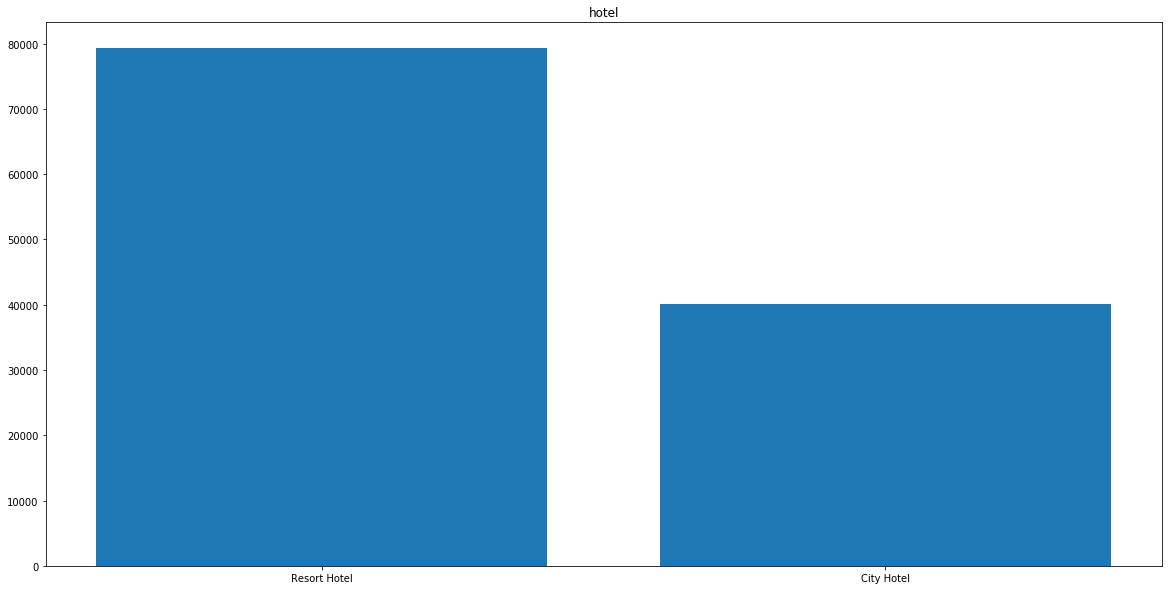

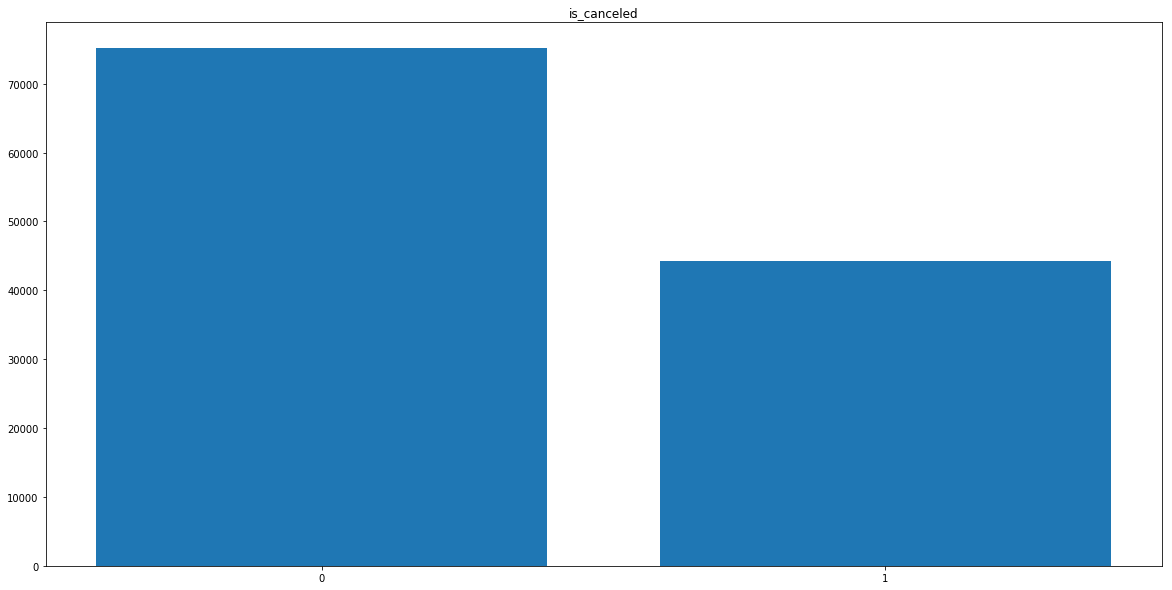

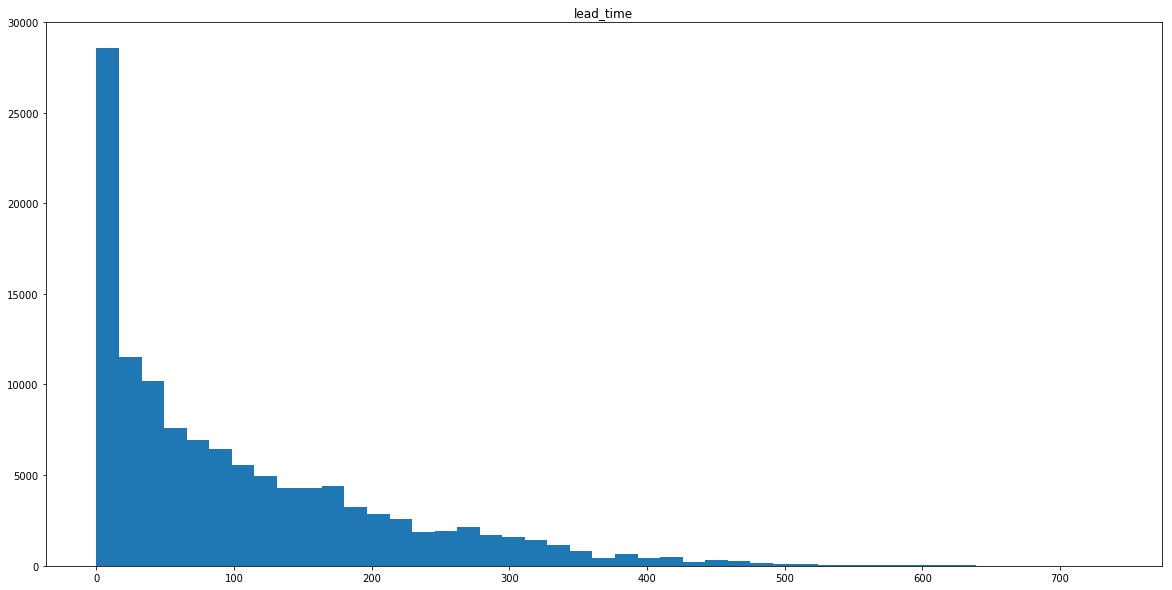

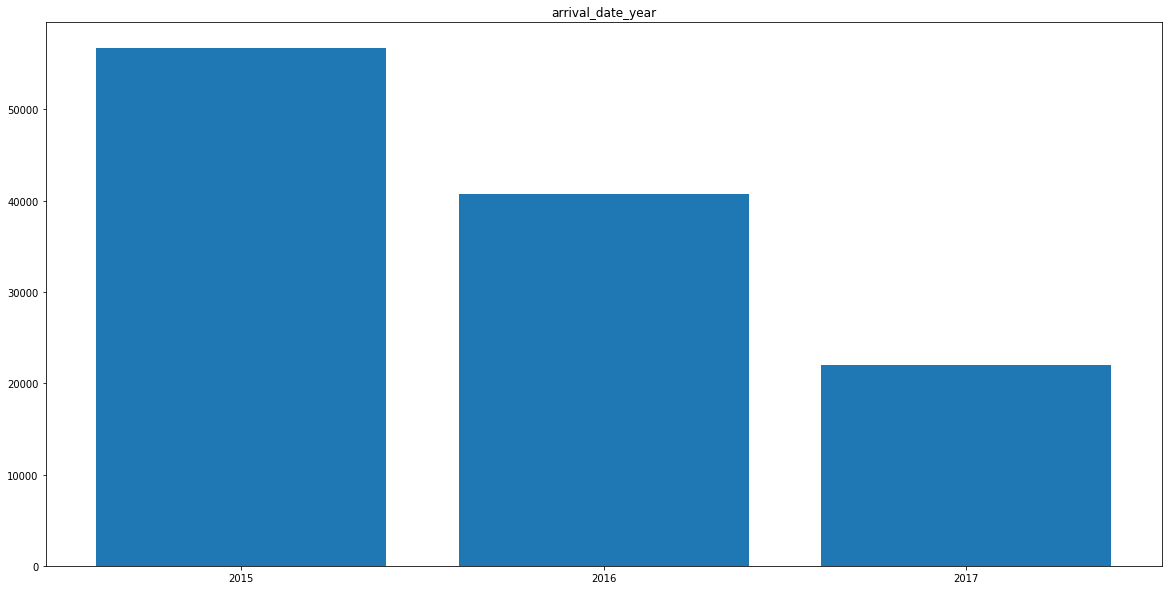

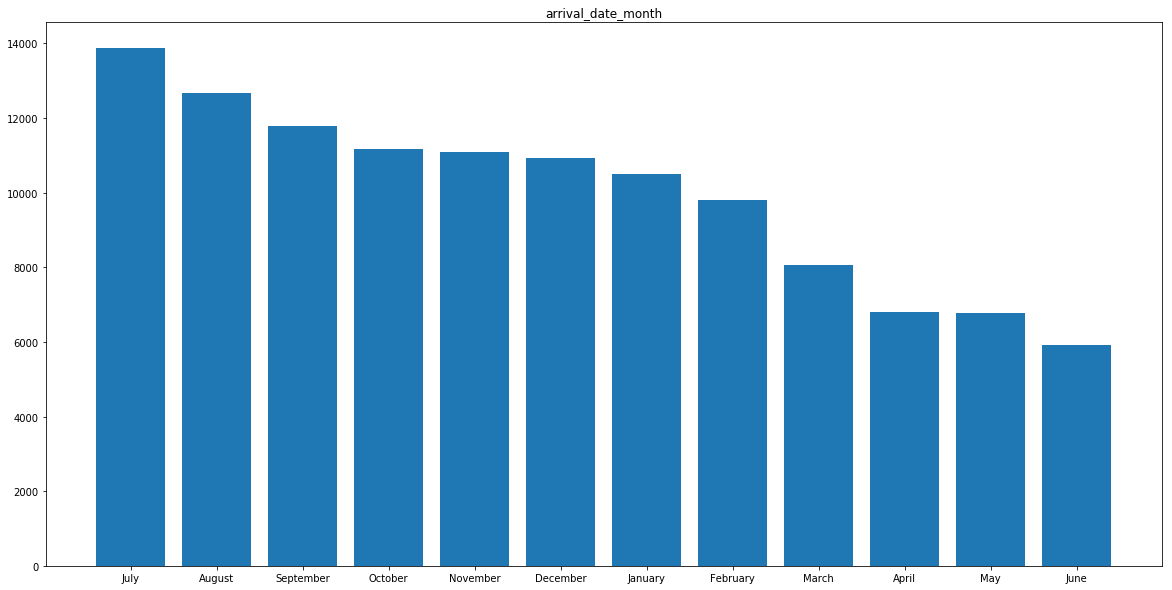

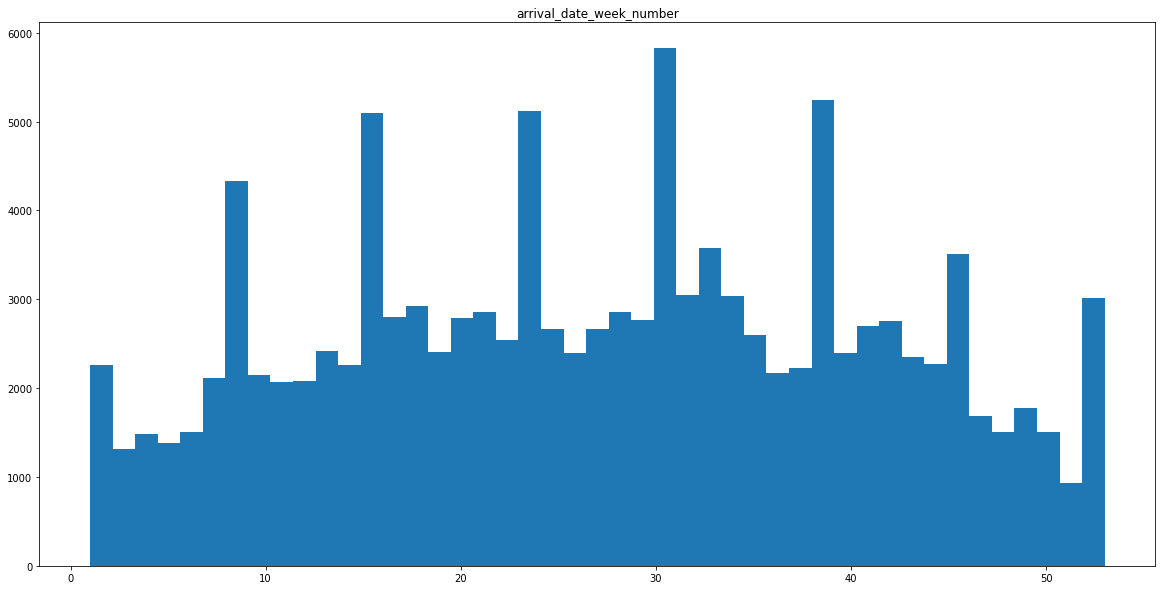

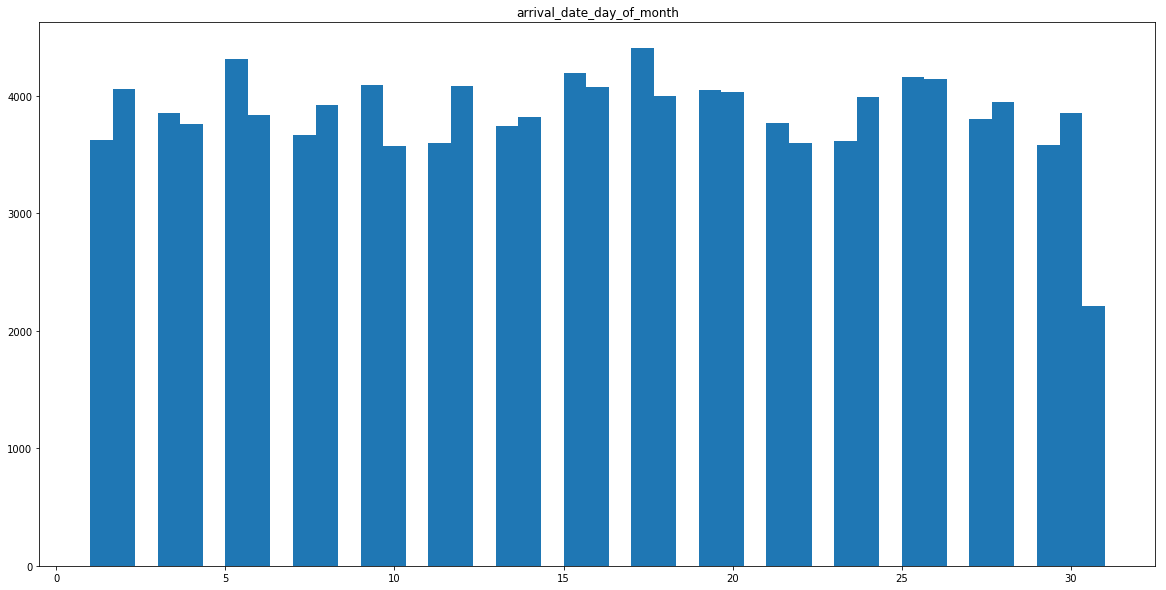

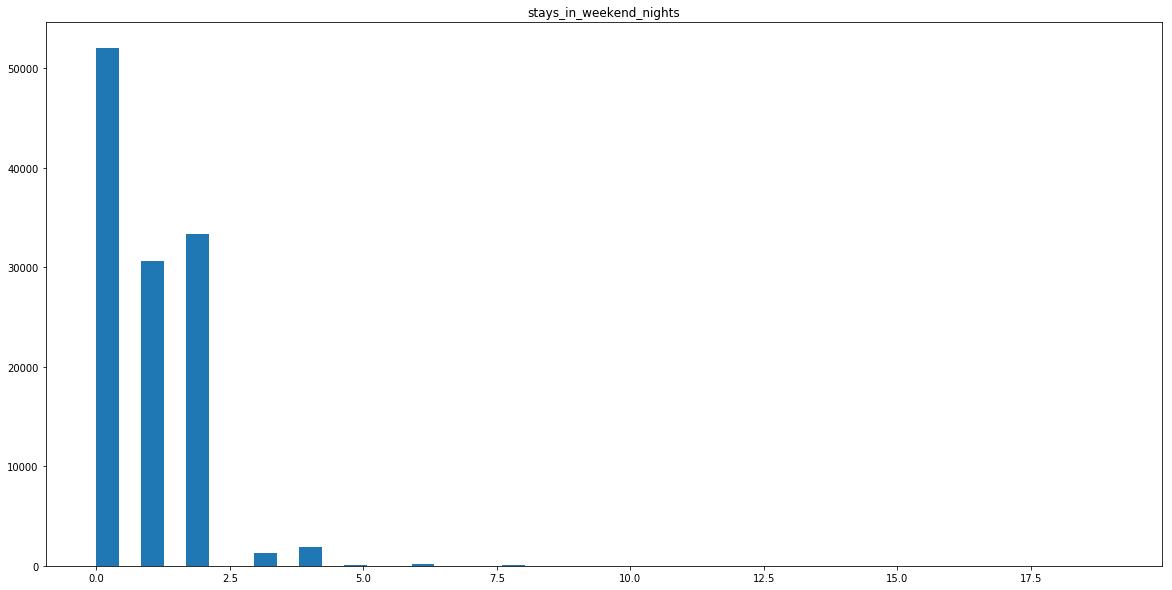

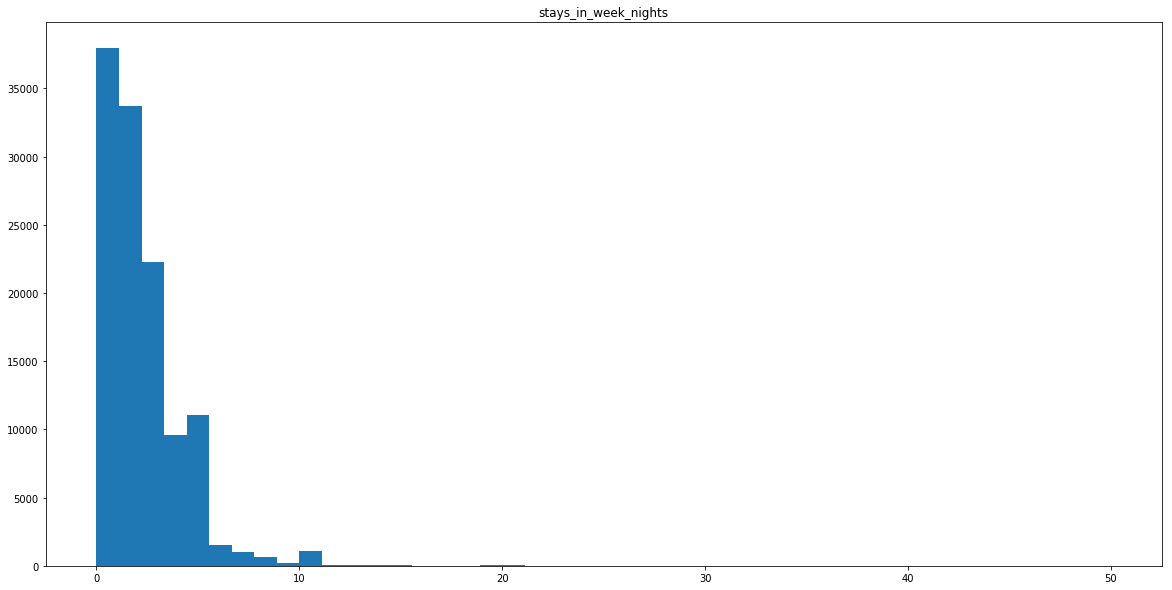

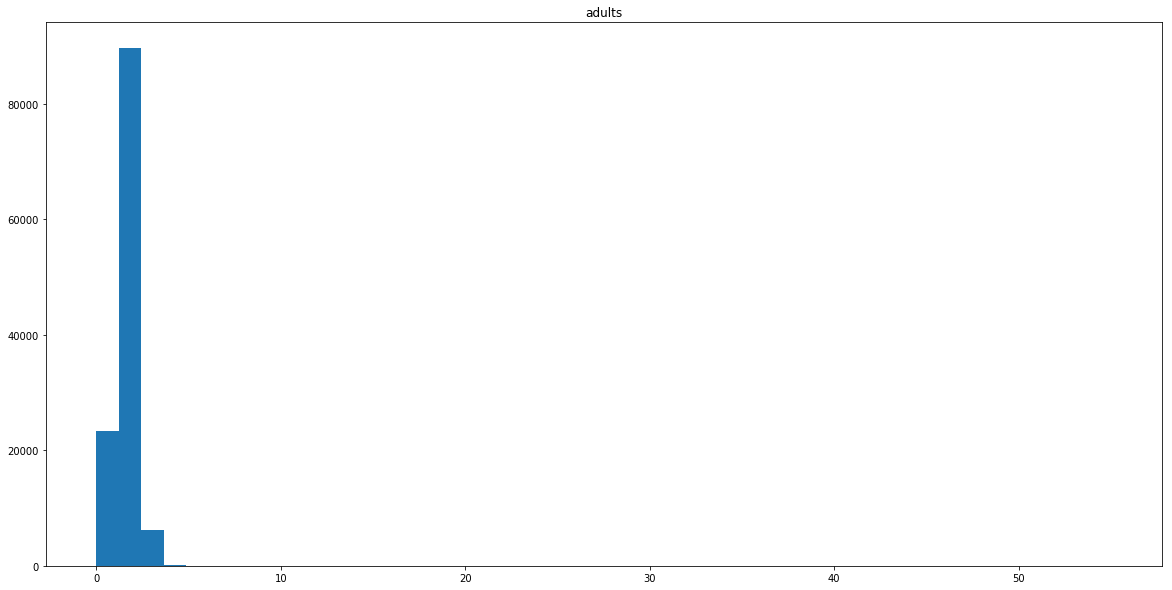

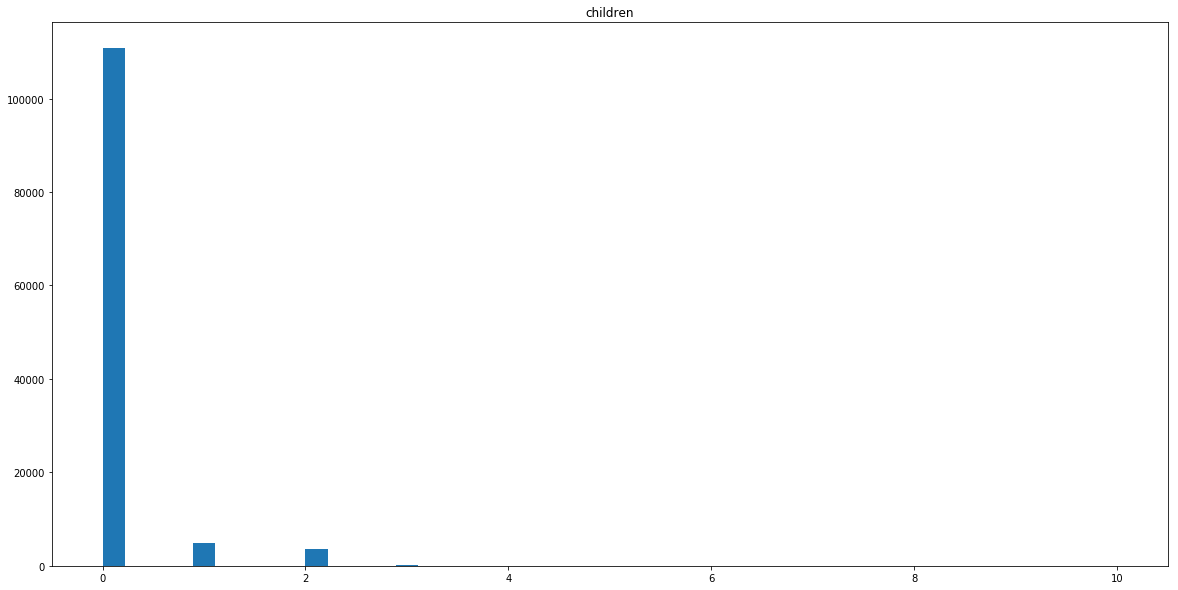

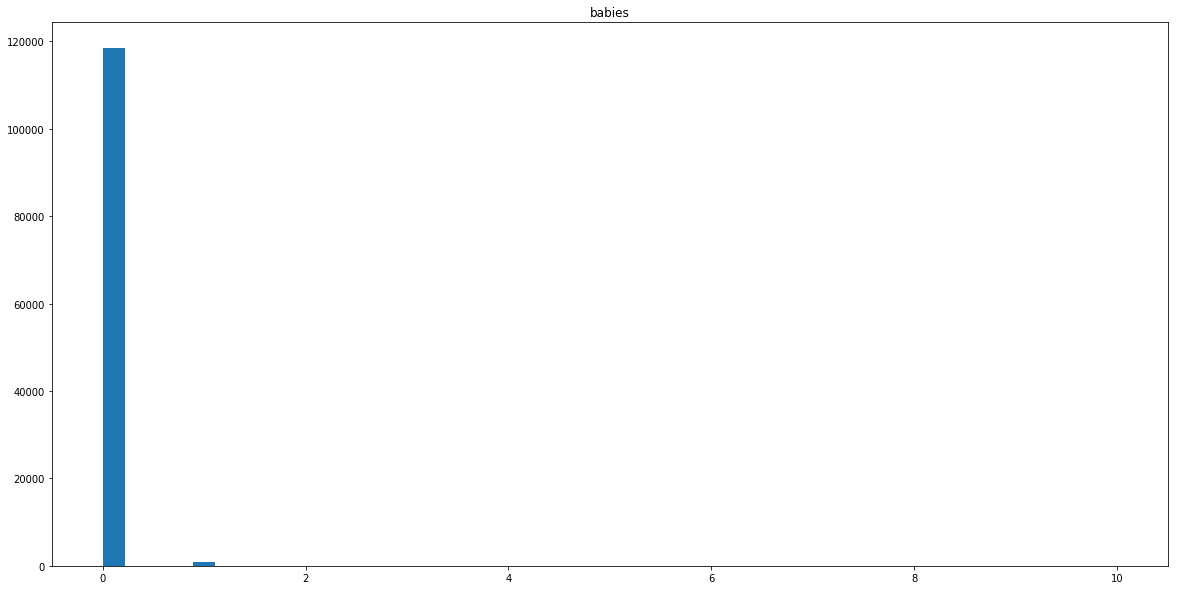

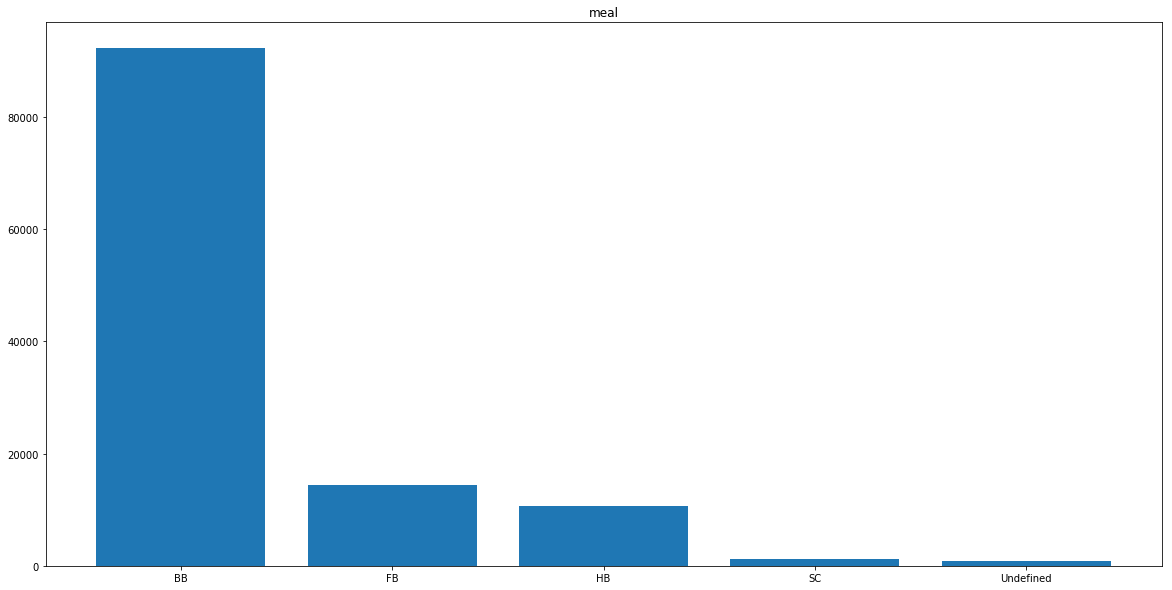

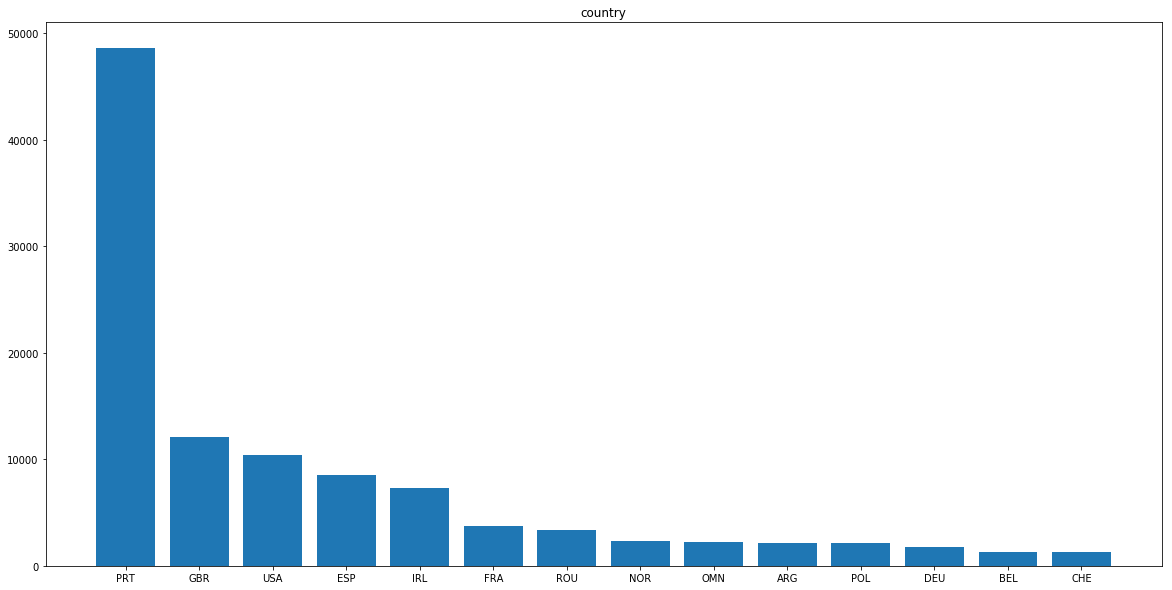

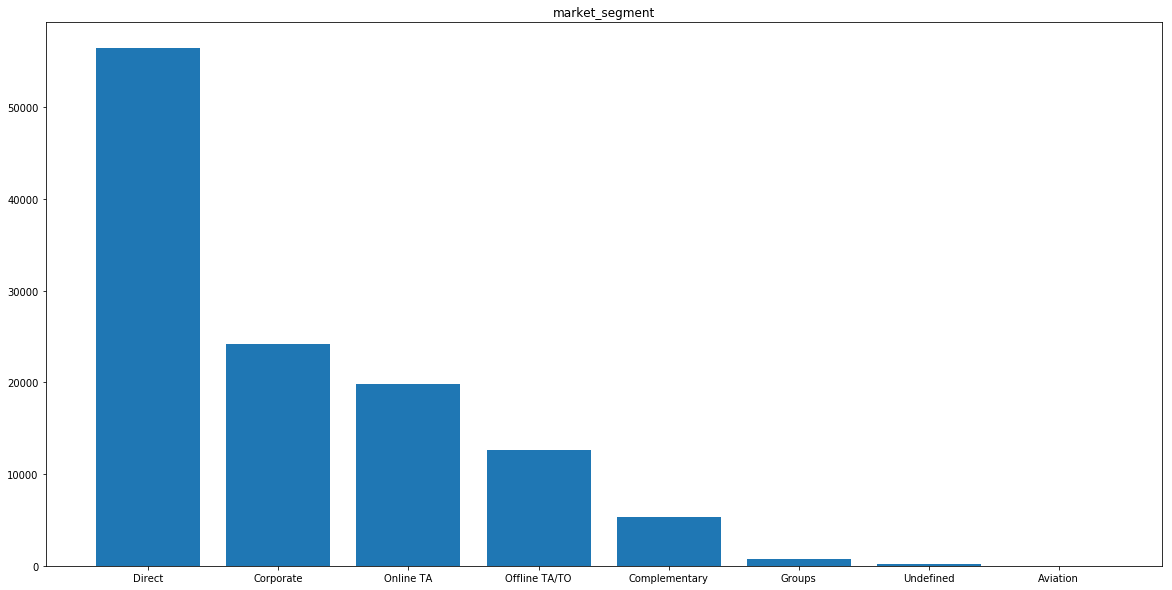

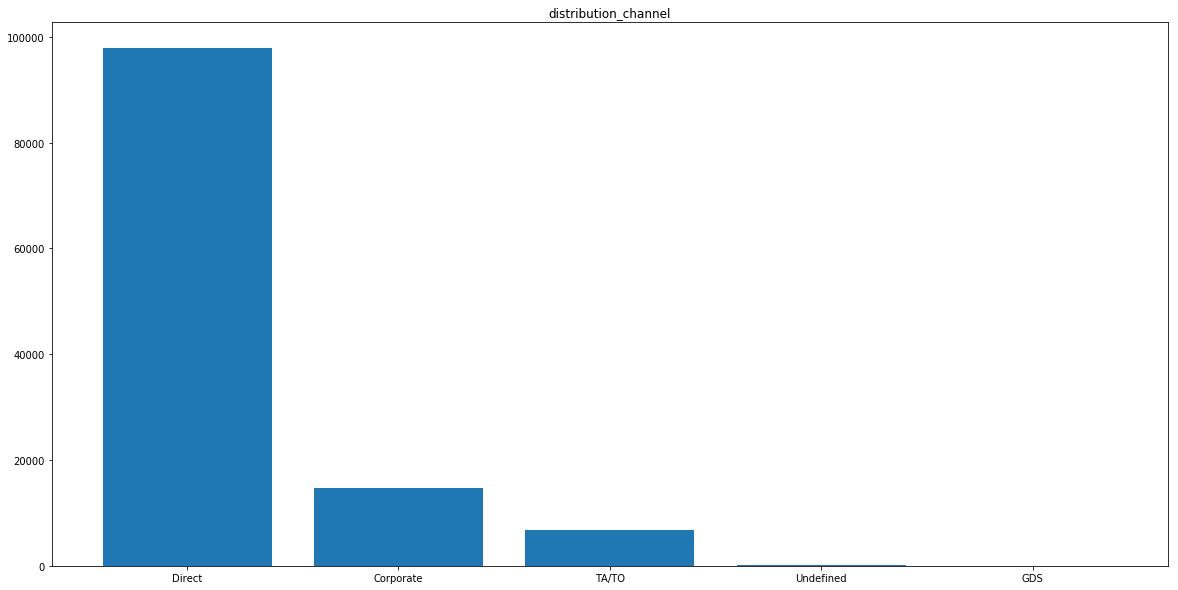

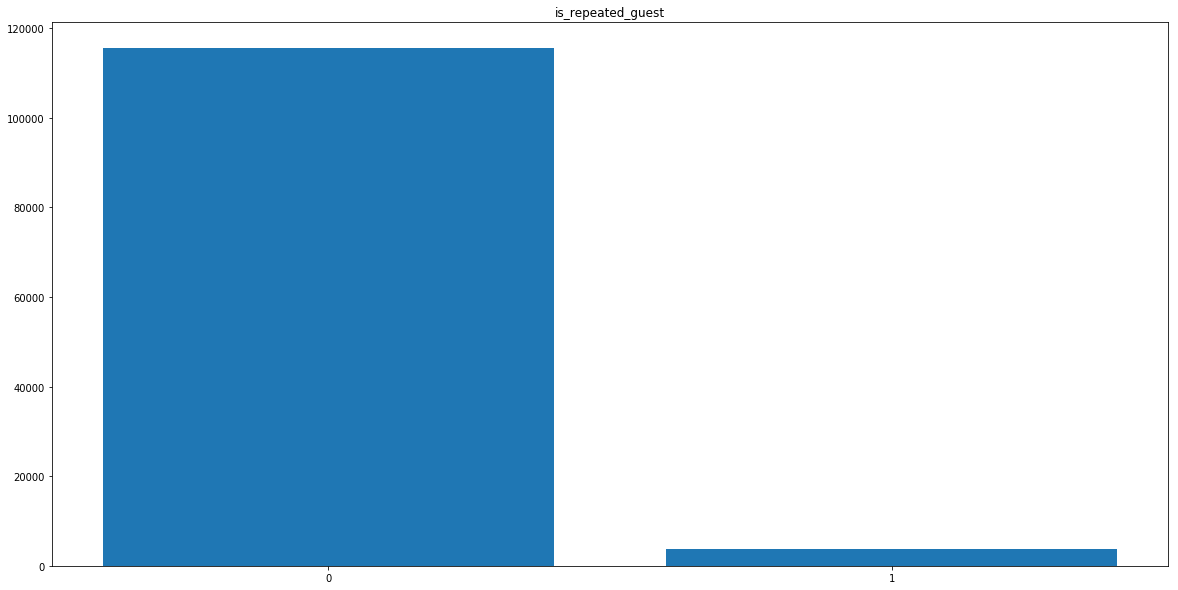

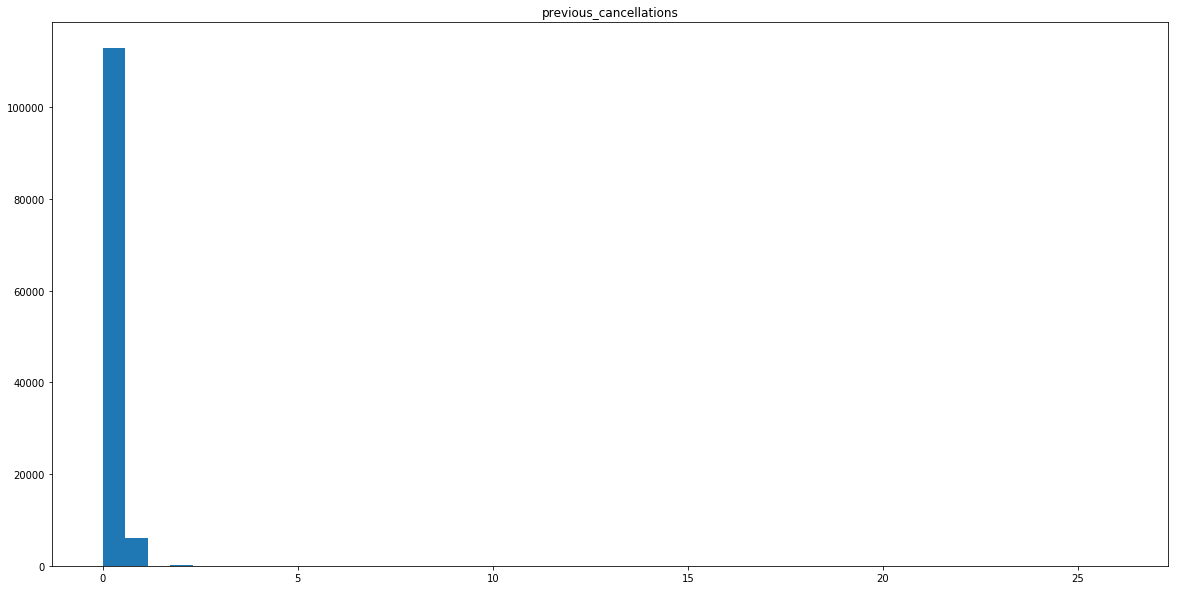

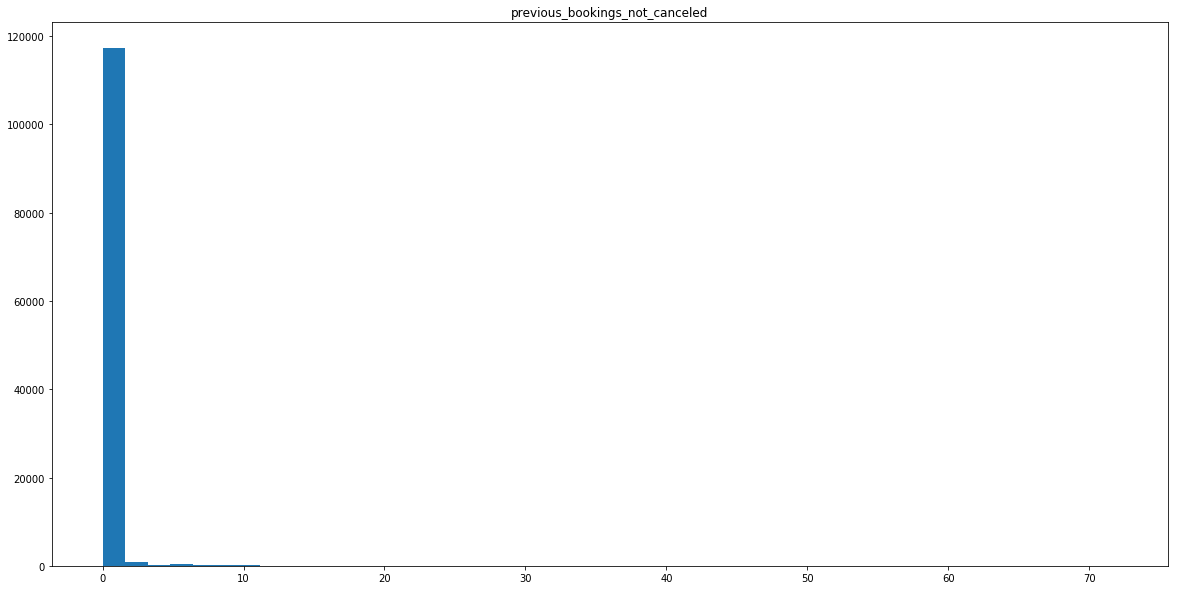

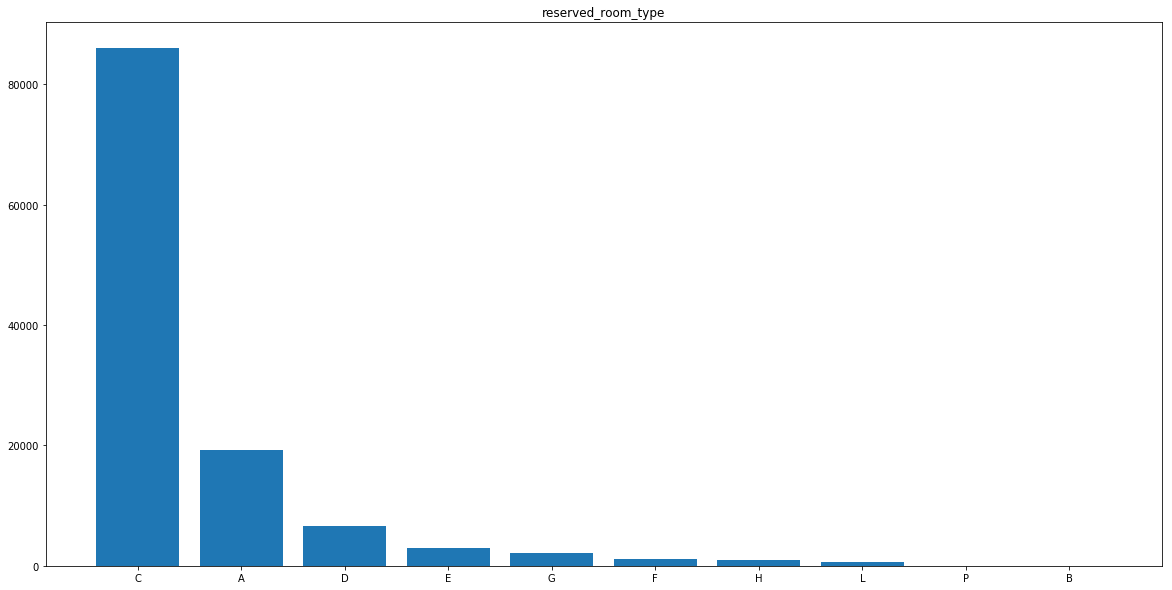

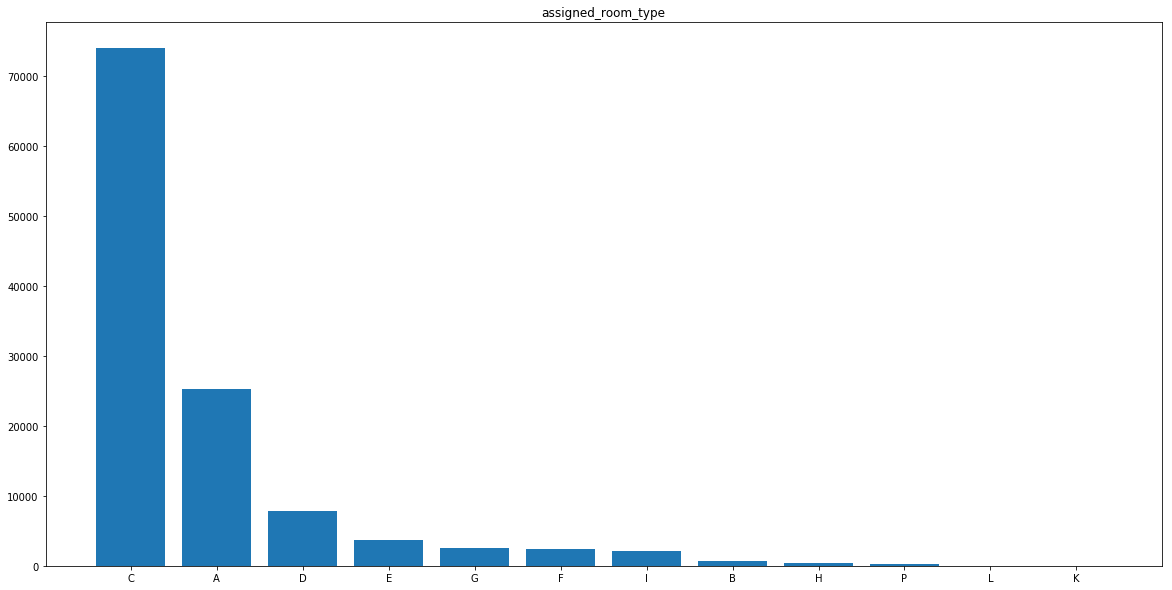

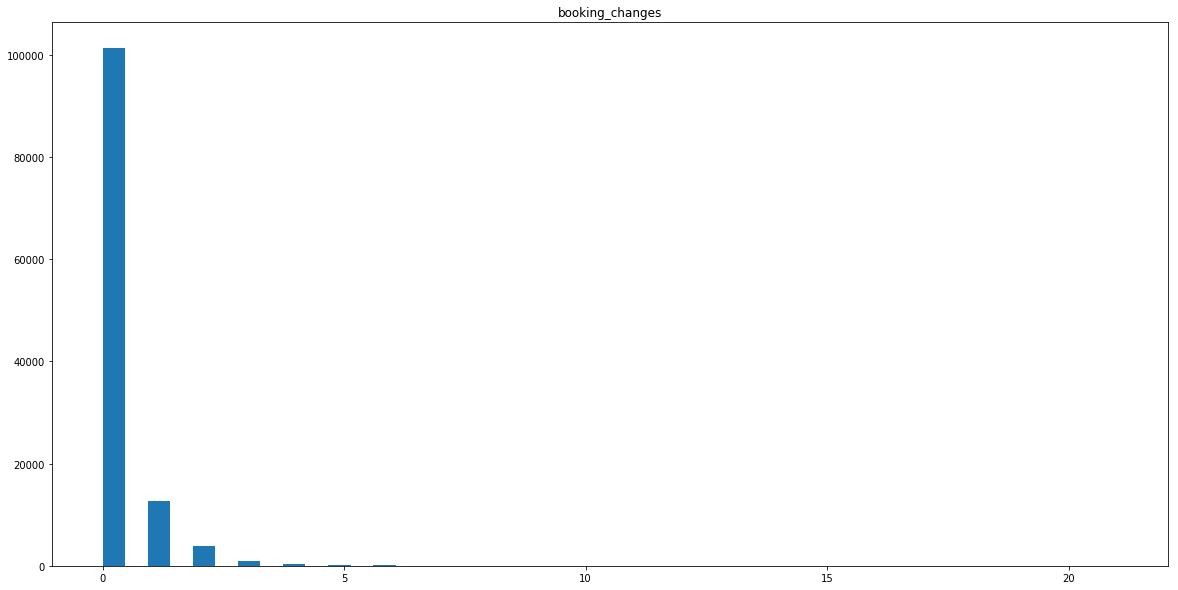

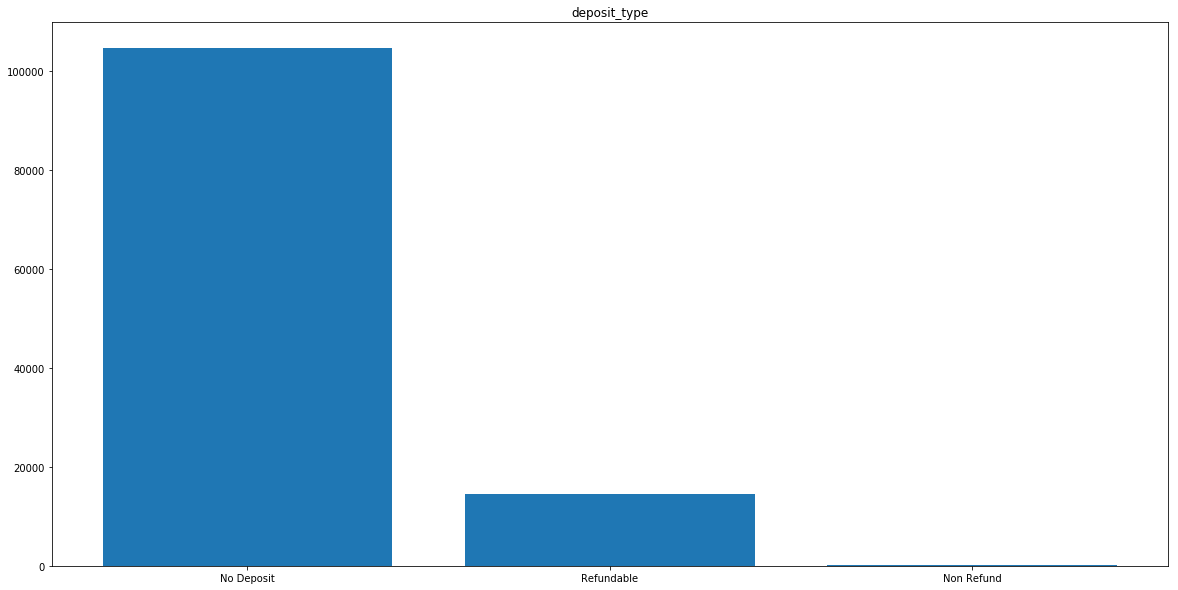

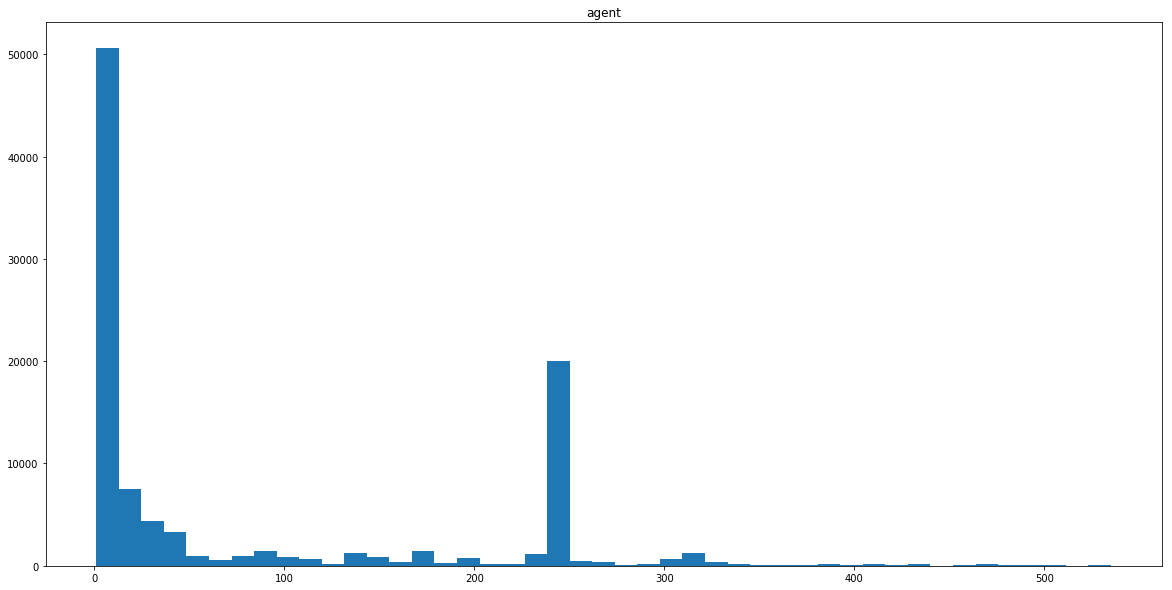

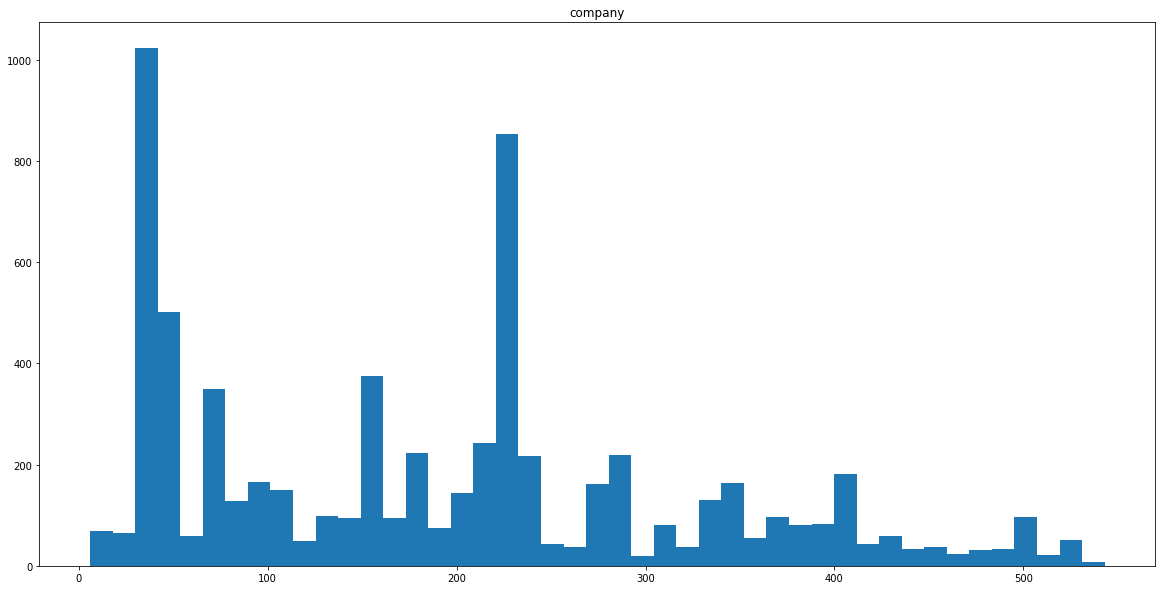

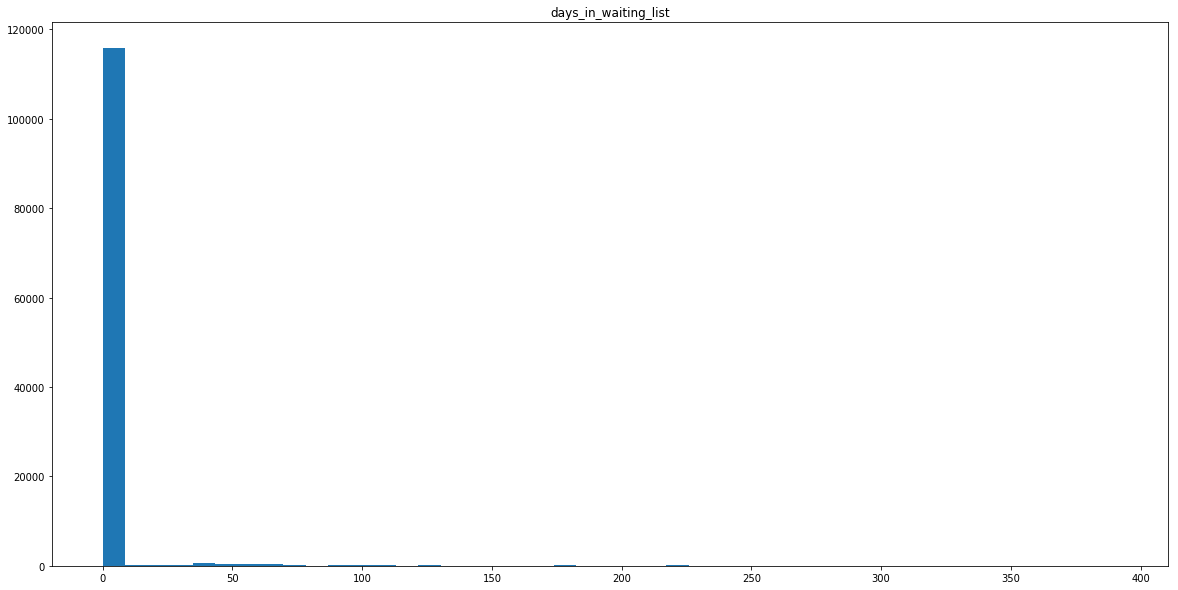

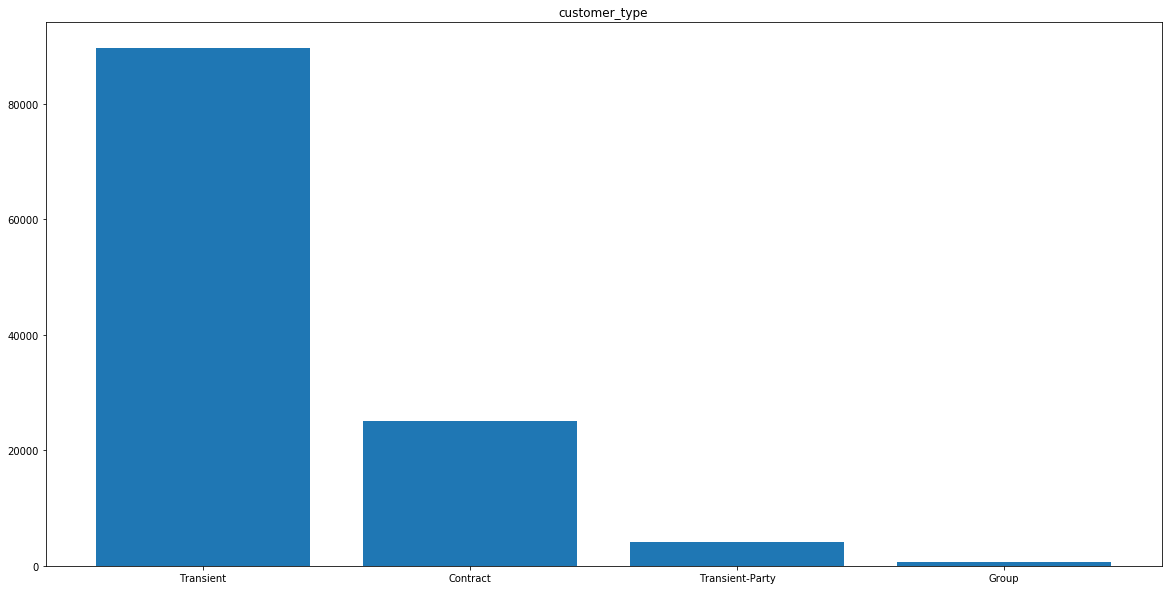

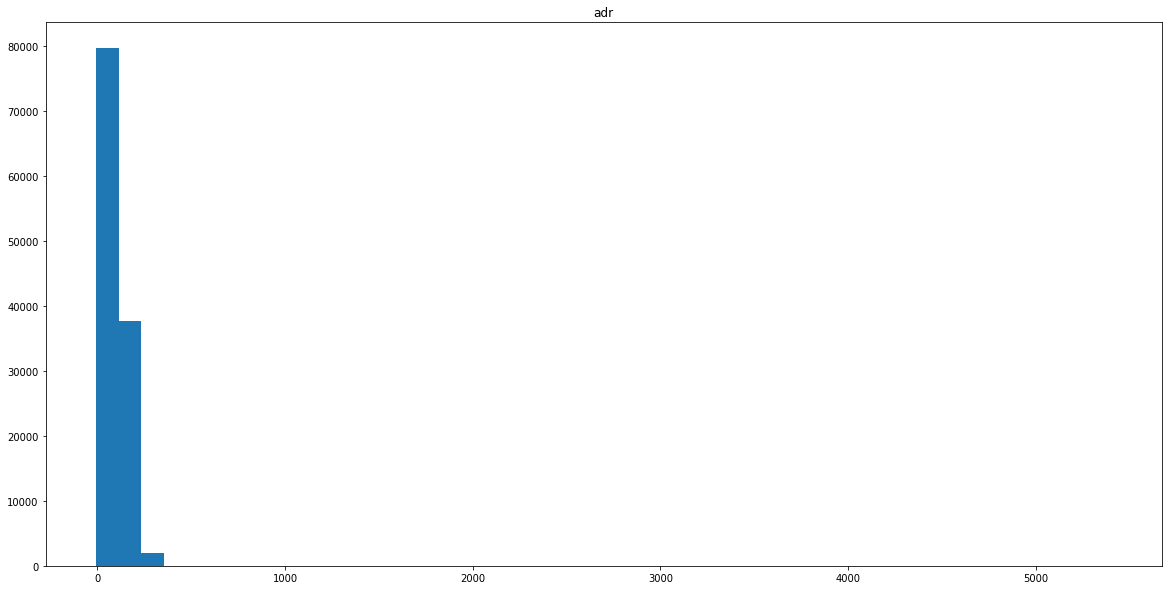

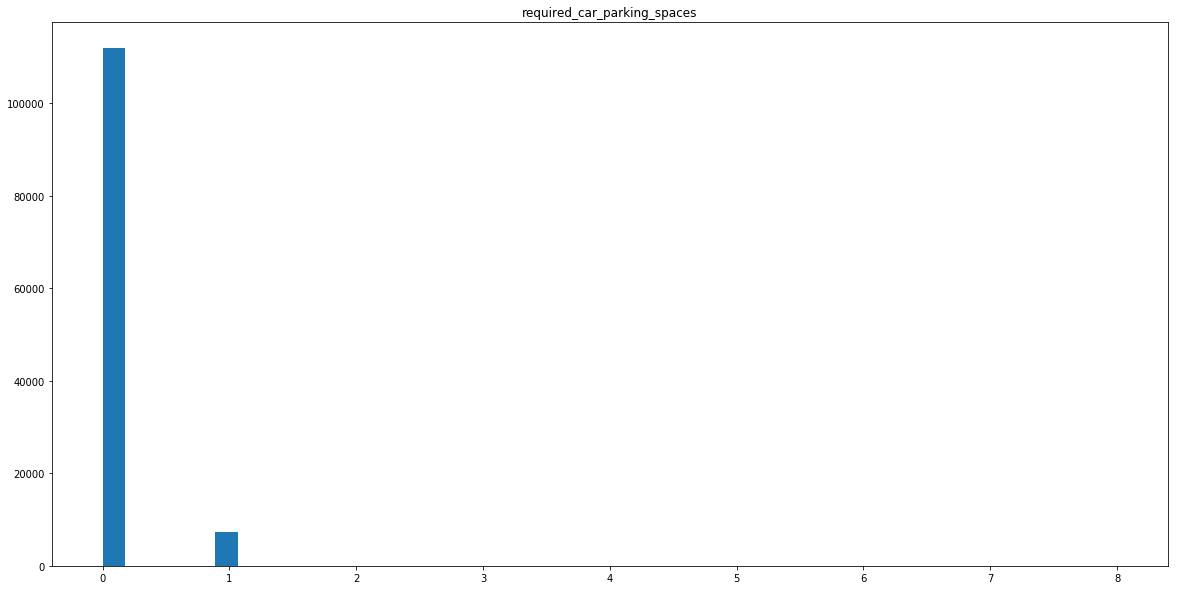

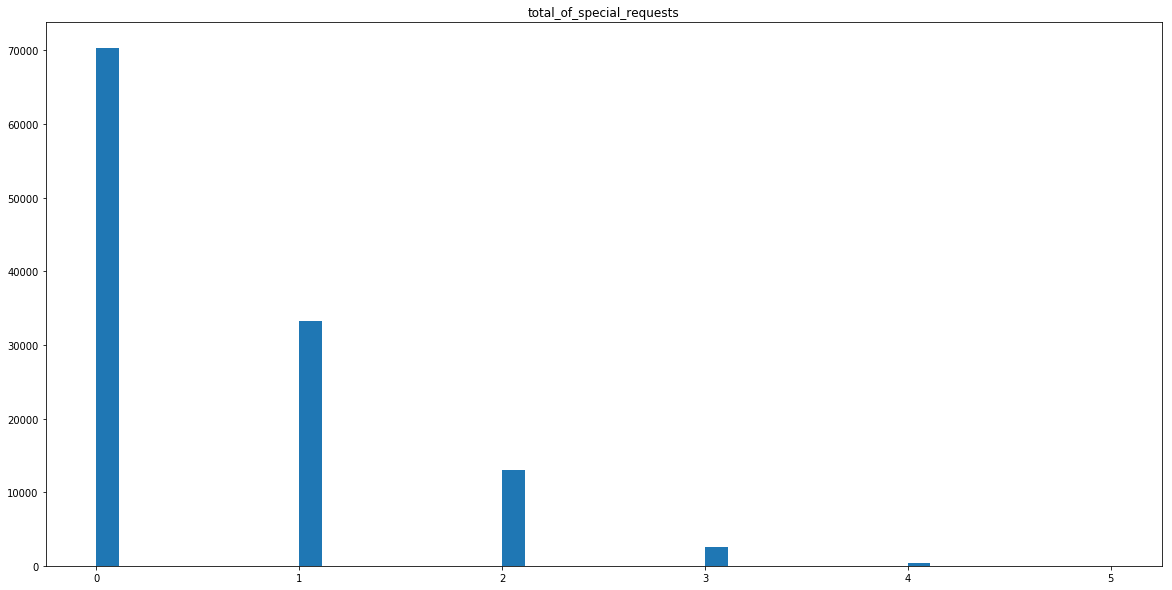

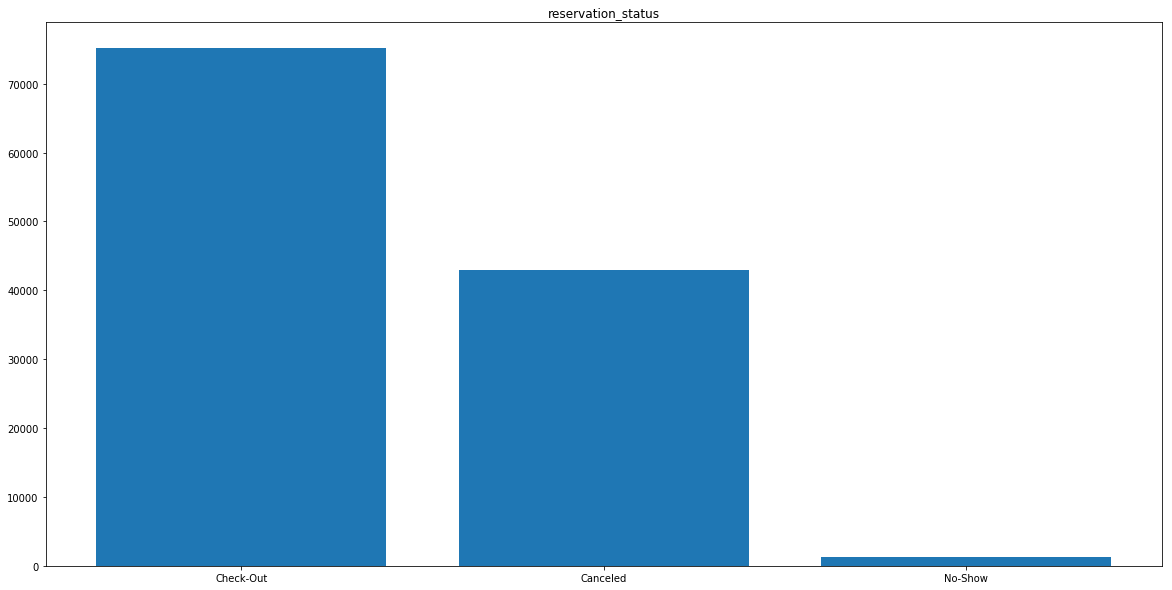

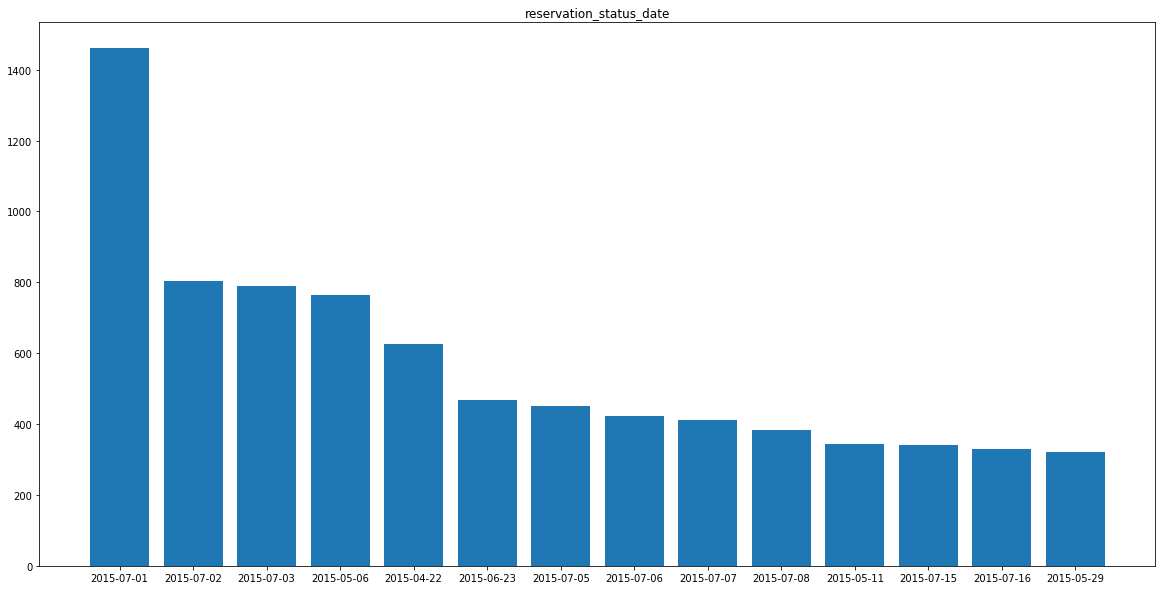

In [15]:
plot_cols(hotel_df,cont_cols)

#### Second step: 

The basic statistical summary is listed by above functions, and we can have a general review of the hotel booking dataset by the histgorams and bar plots. Now, we hope to find more correlation bewteen each features and more complicated relationship and useful information beyond the numbers. Given our prediction aim is to calculate the likelihood of users' reservation cancelation, we would start finding the key factors which play important roles that affect the problem.

#### Graph 1:

Text(0.5, 1.0, 'Frequency plot - [Cancel rate V.S. Hotel types]')

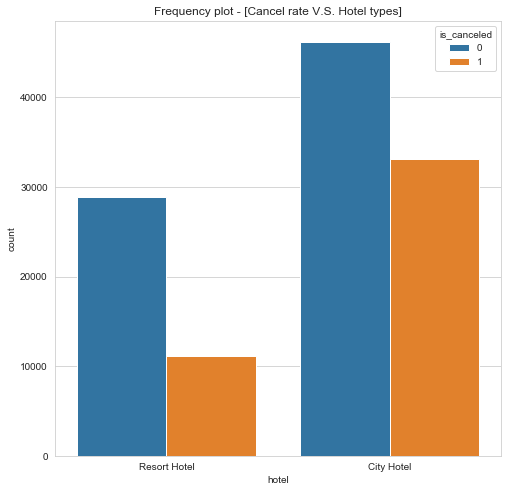

In [16]:
plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
sns.countplot(x="hotel",  hue="is_canceled",data=hotel_df)
plt.title("Frequency plot - [Cancel rate V.S. Hotel types]")

#### Graph 2:

Text(0.5, 1.0, 'Box plot - [Cancel rate V.S. Number of days leading the arrival]')

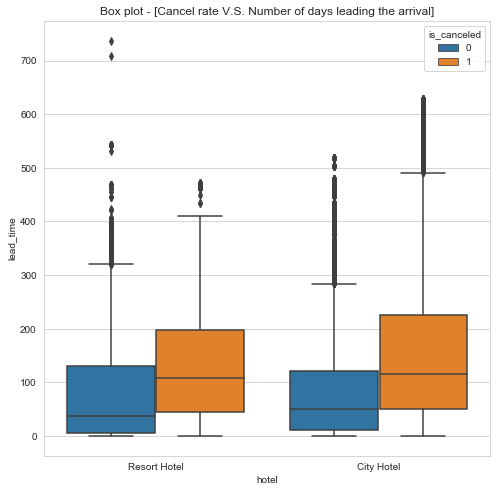

In [17]:
plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
sns.boxplot(x="hotel",y="lead_time",  hue="is_canceled",data=hotel_df)
plt.title("Box plot - [Cancel rate V.S. Number of days leading the arrival]")

#### Graph 3:

/Users/Sssiyuan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Cancelation rate')

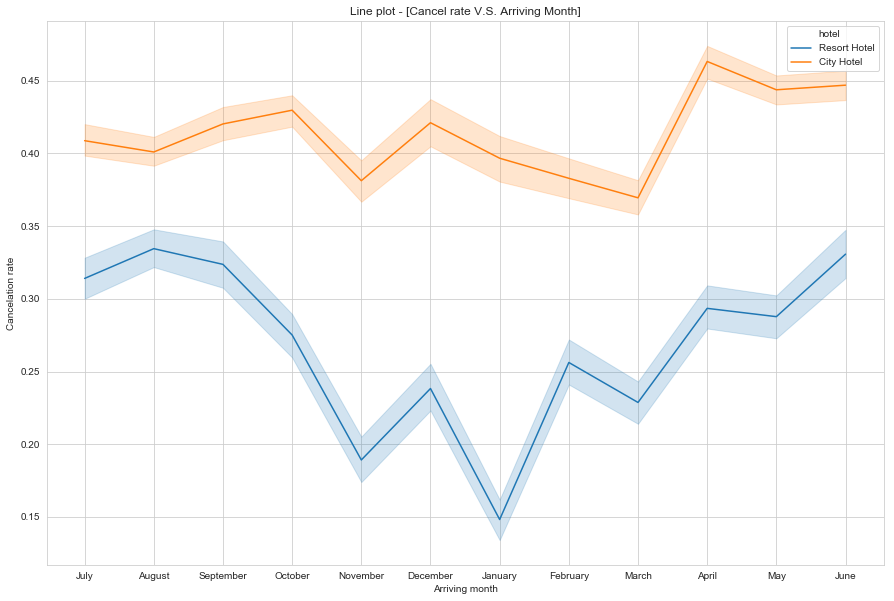

In [18]:
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
sns.lineplot(x="arrival_date_month",y="is_canceled",sort=False,  hue="hotel",data=hotel_df)
plt.title("Line plot - [Cancel rate V.S. Arriving Month]")
plt.xlabel("Arriving month")
plt.ylabel("Cancelation rate")

### III. Data preprocessing:

#### Key point:  We first check the nan values in our dataset, and returned a clean version for encoding.

In [5]:
hotel_df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [44]:
clean_df=hotel_df.drop(columns=['company','reservation_status'])
clean_df=clean_df.dropna(subset=['children','country','agent'])

#### 1. With the prompt to predict cancelation probabilty, we first split our label column and features dataset.

In [45]:
# get feature and label datasets
y = clean_df['is_canceled']
X = clean_df.loc[:, clean_df.columns != 'is_canceled'] # all other columns are features

# reshape label array for encoding
y=pd.Series(y)

#### 2. we now define the encoders for the split

In [46]:
onehot_ftrs = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
               'distribution_channel', 'reserved_room_type', 'assigned_room_type', 
               'deposit_type', 'customer_type', 'reservation_status_date', 
                'arrival_date_year', 'is_repeated_guest']

minmax_ftrs = ['arrival_date_week_number','arrival_date_day_of_month']

std_ftrs =['lead_time', 'stays_in_weekend_nights','stays_in_week_nights', 'adults', 'children', 'agent',
           'babies', 'previous_cancellations','previous_bookings_not_canceled', 'booking_changes', 
           'days_in_waiting_list', 'adr', 'required_car_parking_spaces','total_of_special_requests']


#### 3. Finally, we loop through 10 random states and perform the splitting progress.

In [195]:
random_state=43

# first split to separate out the training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)
# second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)

# collect all the encoders
preprocessor = ColumnTransformer(
transformers=[
    ('minmax', MinMaxScaler(), minmax_ftrs),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
    ('std', StandardScaler(), std_ftrs)])
clf = Pipeline(steps=[('preprocessor', preprocessor)])


# Transforming the datasets with defined encoders
X_train_prep = clf.fit_transform(X_train)
X_val_prep   = clf.transform(X_val)
X_test_prep  = clf.transform(X_test)


# print data points to make sure our code is reproducable
print('   training set:',X_train.shape, y_train.shape) 
print('   preprocessed training set:',X_train_prep.shape, y_train.shape) 
print('   preprocessed validation set:',X_val_prep.shape, y_val.shape) 
print('   preprocessed test set:',X_test_prep.shape, y_test.shape) 

   training set: (61736, 29) (61736,)
   preprocessed training set: (61736, 1143) (61736,)
   preprocessed validation set: (20579, 1143) (20579,)
   preprocessed test set: (20579, 1143) (20579,)


**Intuition:**

This intuition for spliting our dataset is direct. Given our data is in IID form, we first clean the dataset by removing the "nan" values. Then, as the data frame contains about 113000 data points, which is consider a medium sized dataset. We still apply the traditional splitting method with proportion as 60% train, 20% validation, 20% test. Then for 32 columns, we apply three different encoders to transform the feature dataset. The label colunmn is previously assigned into two categories. Then we do not need to fit a encoder for the varible. 

---


In [219]:
1-len(clean_df)/len(hotel_df)

0.13816902588156466

In [220]:
len(clean_df)

102894

### IV. ML Pipeline

In [55]:
clean_df.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,304.0,0,Transient,75.00,0,0,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,0,Transient,98.00,0,1,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,0,Transient,98.00,0,1,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,C,0,No Deposit,303.0,0,Transient,103.00,0,1,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,A,0,No Deposit,240.0,0,Transient,82.00,0,1,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,D,0,No Deposit,15.0,0,Transient,105.50,0,0,2015-04-22
10,Resort Hotel,1,23,2015,July,27,1,0,4,2,...,E,0,No Deposit,240.0,0,Transient,123.00,0,0,2015-06-23
11,Resort Hotel,0,35,2015,July,27,1,0,4,2,...,D,0,No Deposit,240.0,0,Transient,145.00,0,0,2015-07-05
12,Resort Hotel,0,68,2015,July,27,1,0,4,2,...,E,0,No Deposit,240.0,0,Transient,97.00,0,3,2015-07-05
13,Resort Hotel,0,18,2015,July,27,1,0,4,2,...,G,1,No Deposit,241.0,0,Transient,154.77,0,1,2015-07-05


#### Note tha our data is not imbalanced，and our baseline accuracy can be computed as the portion of the largest class.

In [250]:
print(clean_df.is_canceled.value_counts(),'\n')

print("Baseline accuracy for our prediction: ", clean_df.is_canceled.value_counts()[0]/len(clean_df))

0    62733
1    40161
Name: is_canceled, dtype: int64 

Baseline accuracy for our prediction:  0.6096856959589481


### Part One: we calculate the accuracy score for our four machine learning models, and they served as our baseline model

#### (1) Logistic Regresson

In [96]:
log = LogisticRegression(solver='lbfgs')
# fit the model
log.fit(X_train_prep,y_train)

accuracy_score(log.predict(X_test_prep),y_test)

/Users/Sssiyuan/anaconda3/envs/data1030/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8561640507313281

#### (2) Random forest Classification

In [247]:
rf = RandomForestClassifier(n_estimators=1)
# fit the model
rf.fit(X_train_prep, y_train)

accuracy_score(rf.predict(X_test_prep),y_test)

0.8136449778900822

#### (3) KNN Classifiation

In [52]:
knn=neighbors.KNeighborsClassifier(3 , weights='uniform')
# fit the model
knn.fit(X_train_prep, y_train)

accuracy_score(knn.predict(X_test_prep),y_test)

0.8514991010253171

#### (4) XGBoosting Classification

In [154]:
XGB = xgboost.XGBClassifier(max_depth=20)
# fit the model
XGB.fit(X_train_prep, y_train)

accuracy_score(XGB.predict(X_test_prep),y_test)

0.9230769230769231

### Part Two: we will apply hyperparameter tuning for above models.

#### (1) Logistic Regression Pipeline

In [132]:
def MLpipe_LG_ACC(X,y):
    '''
    This function splits the data to other/test (80/20) and then applies train/val (60/20) split.
    The Accuracy score is calcualted as the evalutation metric.
    '''
    
    test_scores = []
    val_scores = []
    train_scores = []
    param_grid=['lbfgs','sag','saga']
    
    # loop through 10 random states (2 points)
    for i in range(0,5):
        random_state=7 * i
        
        # first split to separate out the training set
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)
        # second split to separate out the validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)

        # collect all the encoders
        preprocessor = ColumnTransformer(
        transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])
        clf = Pipeline(steps=[('preprocessor', preprocessor)])


        # Transforming the datasets with defined encoders
        X_train_prep = clf.fit_transform(X_train)
        X_val_prep   = clf.transform(X_val)
        X_test_prep  = clf.transform(X_test)

        for slvr in param_grid:
            log = LogisticRegression(solver=slvr)
            # fit the model
            log.fit(X_train_prep,y_train)
            acy=accuracy_score(log.predict(X_test_prep),y_test)
            val=accuracy_score(log.predict(X_val_prep),y_val)
            trn=accuracy_score(log.predict(X_train_prep),y_train)
            
            test_scores.append(acy)
            val_scores.append(val)
            train_scores.append(trn)
        
        
    return test_scores, val_scores, train_scores

#### model performance

In [133]:
test_scr, val_scr, train_scr= MLpipe_LG_ACC(X,y)

/Users/Sssiyuan/anaconda3/envs/data1030/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Sssiyuan/anaconda3/envs/data1030/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/Sssiyuan/anaconda3/envs/data1030/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not

#### print the result:

In [158]:
print("train score:", train_scr, "\n")

print("val score:", val_scr,"\n")

print("test score:", test_scr)

train score: [0.8626571206427368, 0.8285603213684074, 0.8204451211610729, 0.8618310224180381, 0.827248283011533, 0.8189387067513282, 0.8615880523519502, 0.8284307373331605, 0.8189387067513282, 0.8628352986912012, 0.8279609952053907, 0.8192302708306337, 0.8625113386030842, 0.8292730335622651, 0.8214331994298303] 

val score: [0.8488264735895816, 0.8212255211623499, 0.8130132659507264, 0.8562612371835366, 0.8262792166771952, 0.8185528937266145, 0.8525195587735069, 0.824335487633024, 0.8158802662908791, 0.8601486952718791, 0.8294377763739734, 0.8211283347101415, 0.8546090674959911, 0.8303124544438505, 0.8216142669711842] 

test score: [0.8534914232955926, 0.8262306234510909, 0.8181641479177802, 0.8514019145731085, 0.820010690509743, 0.8130618591768307, 0.856844355896788, 0.8259390640944653, 0.8183585208221974, 0.8551921862092424, 0.8263278099032995, 0.8185528937266145, 0.8515962874775256, 0.8203508430924729, 0.8124301472374751]


----
#### (2) Random Forest Pipeline

In [143]:
def MLpipe_RF_ACC(X,y):
    '''
    This function splits the data to other/test (80/20) and then applies train/val (60/20) split.
    The Accuracy score is calcualted as the evalutation metric.
    '''
    
    test_scores = []
    val_scores = []
    train_scores = []
    param_grid=[1,3,10,30,100,200]
    
    # loop through 10 random states (2 points)
    for i in range(0,5):
        random_state=7 * i
        
        # first split to separate out the training set
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)
        # second split to separate out the validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)

        # collect all the encoders
        preprocessor = ColumnTransformer(
        transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])
        clf = Pipeline(steps=[('preprocessor', preprocessor)])


        # Transforming the datasets with defined encoders
        X_train_prep = clf.fit_transform(X_train)
        X_val_prep   = clf.transform(X_val)
        X_test_prep  = clf.transform(X_test)

        for dpth in param_grid:
            rf = RandomForestClassifier(n_estimators=1,max_depth=dpth)
            # fit the model
            rf.fit(X_train_prep, y_train)

            acy=accuracy_score(rf.predict(X_test_prep),y_test)
            val=accuracy_score(rf.predict(X_val_prep),y_val)
            trn=accuracy_score(rf.predict(X_train_prep),y_train)
            
            test_scores.append(acy)
            val_scores.append(val)
            train_scores.append(trn)
        
        
    return test_scores, val_scores, train_scores

#### model performance

In [144]:
rftest_scr, rfval_scr, rftrain_scr= MLpipe_RF_ACC(X,y)

#### print the result:

In [145]:
print("train score:", rftrain_scr, "\n")

print("val score:", rfval_scr,"\n")

print("test score:", rftest_scr)

train score: [0.642914992872878, 0.6199624206297785, 0.7595892186082674, 0.8265193728132694, 0.9318549954645587, 0.9372813269405209, 0.6133698328365945, 0.6502688868731372, 0.6846896462355838, 0.8206718932227549, 0.9341551120901905, 0.9397434236102112, 0.6097252818452766, 0.6120901904885319, 0.7023940650511857, 0.8257256705973824, 0.934219904107814, 0.9387229493326422, 0.6079111053518207, 0.6615588959440197, 0.7270312297524945, 0.8137229493326422, 0.9301056109887262, 0.9354509524426591, 0.6100492419333938, 0.6287579370221589, 0.7285862381754568, 0.8142898794868472, 0.9326810936892574, 0.9347220422443955] 

val score: [0.6365712619660819, 0.6113513776179601, 0.7512998687982895, 0.7941590942222654, 0.8137421643422906, 0.829875115408912, 0.616696632489431, 0.653335924972059, 0.68637931872297, 0.7998445016764663, 0.8228290976237912, 0.8337625734972545, 0.610136546965353, 0.6124690218183585, 0.7020263375285485, 0.8048010107391029, 0.8300694883133292, 0.8303124544438505, 0.6157733611934496, 

---
#### (3) XGBoost Pipeline

In [155]:
def MLpipe_XGB_ACC(X,y):
    '''
    This function splits the data to other/test (80/20) and then applies train/val (60/20) split.
    The Accuracy score is calcualted as the evalutation metric.
    '''
    
    test_scores = []
    val_scores = []
    train_scores = []
    param_grid = [3,6,10,20]
    
    # loop through 10 random states (2 points)
    for i in range(0,5):
        random_state=7 * i
        
        # first split to separate out the training set
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)
        # second split to separate out the validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)

        # collect all the encoders
        preprocessor = ColumnTransformer(
        transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])
        clf = Pipeline(steps=[('preprocessor', preprocessor)])


        # Transforming the datasets with defined encoders
        X_train_prep = clf.fit_transform(X_train)
        X_val_prep   = clf.transform(X_val)
        X_test_prep  = clf.transform(X_test)

        for dpth in param_grid:
            XGB = xgboost.XGBClassifier(max_depth=dpth)
            # fit the model
            XGB.fit(X_train_prep, y_train)
        
            acy=accuracy_score(XGB.predict(X_test_prep),y_test)
            val=accuracy_score(XGB.predict(X_val_prep),y_val)
            trn=accuracy_score(XGB.predict(X_train_prep),y_train)
            
            test_scores.append(acy)
            val_scores.append(val)
            train_scores.append(trn)
        
        
    return test_scores, val_scores, train_scores

#### model performance

In [156]:
xgbtest_scr, xgbval_scr, xgbtrain_scr= MLpipe_XGB_ACC(X,y)

#### print the result:

In [157]:
print("train score:", xgbtrain_scr, "\n")

print("val score:", xgbval_scr,"\n")

print("test score:", xgbtest_scr)

train score: [0.865362187378515, 0.8926720228067903, 0.9247116755215757, 0.986166904237398, 0.8625761306207075, 0.8910198263573927, 0.9225735389400026, 0.9828463133341973, 0.8612316962550214, 0.8914085784631334, 0.9223143708695088, 0.9860697162109628, 0.8656699494622263, 0.8941136451989115, 0.9204516003628354, 0.9878029026823896, 0.8632564468057535, 0.8918459245820914, 0.9195283141117014, 0.9842555397175068] 

val score: [0.8562126439574324, 0.8773021040866903, 0.899557801642451, 0.9214247533893776, 0.8604402546285048, 0.8827931386364741, 0.9050488361922348, 0.9216677195198989, 0.8606346275329219, 0.8840565625151854, 0.9068953787841975, 0.9282278050439768, 0.8633072549686573, 0.8858059186549395, 0.9023276155303951, 0.9259925166431799, 0.8617036785072161, 0.8864862238203994, 0.9049516497400263, 0.9240487875990087] 

test score: [0.8593226104281063, 0.8803148841051558, 0.9013071577822052, 0.9231741095291316, 0.8571359152534137, 0.8806550366878857, 0.9021818358520822, 0.9201127362845619, 

### V. Result Analysis

### Part I, we summarize the result by tuning ML model hyperparameters

#### (1) Logistic Regression

In [159]:
def get_mean_std_lg(score):
    array1 = [score[i] for i in range(0, len(score), 3)]
    array2 = [score[i] for i in range(1, len(score), 3)]
    array3 = [score[i] for i in range(2, len(score), 3)]
    
    mean_list=[np.mean(array1),np.mean(array2), np.mean(array3)]
    std_list=[np.std(array1),np.std(array2), np.std(array3)]

    return  mean_list, std_list

In [166]:
tr_mean, tr_std=get_mean_std_lg(train_scr)
val_mean, val_std=get_mean_std_lg(val_scr)
test_mean, test_std=get_mean_std_lg(test_scr)


solvers=pd.Series(['lbfgs','sag','saga'])

lgdf = pd.DataFrame({"mean":tr_mean+val_mean+test_mean,
                   "stderr":tr_std+val_std+test_std,
                   "group":np.repeat(['train score','validation score','test score'],3),
                   "solver":['lbfgs','sag','saga']*3})

lgdf

,mean,stderr,group,solver
0,0.862285,0.000487,train score,lbfgs
1,0.828295,0.000671,train score,sag
2,0.819797,0.000989,train score,saga
3,0.854473,0.003772,validation score,lbfgs
4,0.826318,0.003333,validation score,sag
5,0.818038,0.003241,validation score,saga
6,0.853705,0.002091,test score,lbfgs
7,0.823772,0.002937,test score,sag
8,0.816114,0.002760,test score,saga


#### (2) Random Forest:

In [177]:
def get_mean_std_rf(score):
    array1 = [score[i] for i in range(0, len(score), 6)]
    array2 = [score[i] for i in range(1, len(score), 6)]
    array3 = [score[i] for i in range(2, len(score), 6)]
    array4 = [score[i] for i in range(3, len(score), 6)]
    array5 = [score[i] for i in range(4, len(score), 6)]
    array6 = [score[i] for i in range(5, len(score), 6)]
    
    mean_list=[np.mean(array1),np.mean(array2), np.mean(array3), np.mean(array4), np.mean(array5), np.mean(array6)]
    std_list=[np.std(array1),np.std(array2), np.std(array3), np.std(array4), np.std(array5), np.std(array6)]

    return  mean_list, std_list
    

In [181]:
tr_mean, tr_std=get_mean_std_rf(rftrain_scr)
val_mean, val_std=get_mean_std_rf(rfval_scr)
test_mean, test_std=get_mean_std_rf(rftest_scr)

rf_depth=pd.Series(["1","3","10","30","100","200"])

rfdf = pd.DataFrame({"mean":tr_mean+val_mean+test_mean,
                   "stderr":tr_std+val_std+test_std,
                   "group":np.repeat(['train score','validation score','test score'],6)})
rfdf

,mean,stderr,group
0,0.616794,0.013179,train score
1,0.634528,0.018587,train score
2,0.720458,0.025480,train score
3,0.820186,0.005433,train score
4,0.932603,0.001538,train score
5,0.937184,0.001897,train score
6,0.618154,0.009532,validation score
7,0.635045,0.021744,validation score
8,0.719705,0.022866,validation score
9,0.795685,0.005922,validation score


#### Show a figure which shows the mean and stdev of the train and validation score

Text(0, 0.5, 'metric scores')

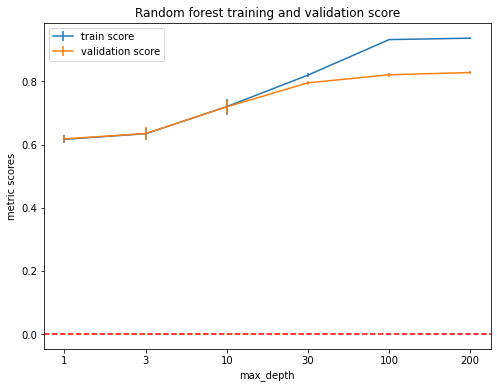

In [185]:
plt.figure(figsize=(8,6))
for i in ['train score','validation score']:
    plt.errorbar(rf_depth,
                rfdf[rfdf['group']==i]["mean"], 
                yerr=rfdf[rfdf['group']==i]["stderr"],label=i)
plt.axhline(y=0 , color='r', linestyle='--')
plt.legend(loc='upper left')
plt.title("Random forest training and validation score")
plt.xlabel('max_depth')
plt.ylabel('metric scores')
 

Text(0, 0.5, 'metric scores')

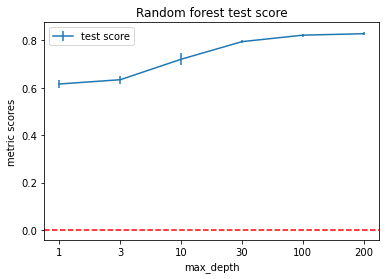

In [184]:
plt.errorbar(rf_depth, test_mean,  test_std,label="test score")
plt.axhline(y=0 , color='r', linestyle='--')
plt.legend(loc='upper left')
plt.title("Random forest test score")
plt.xlabel('max_depth')
plt.ylabel('metric scores')

#### (3) XGBoost 

In [186]:
def get_mean_std_xgb(score):
    array1 = [score[i] for i in range(0, len(score), 6)]
    array2 = [score[i] for i in range(1, len(score), 6)]
    array3 = [score[i] for i in range(2, len(score), 6)]
    array4 = [score[i] for i in range(3, len(score), 6)]

    mean_list=[np.mean(array1),np.mean(array2), np.mean(array3), np.mean(array4)]
    std_list=[np.std(array1),np.std(array2), np.std(array3), np.std(array4)]

    return  mean_list, std_list 

In [188]:
tr_mean, tr_std=get_mean_std_xgb(xgbtrain_scr)
val_mean, val_std=get_mean_std_xgb(xgbval_scr)
test_mean, test_std=get_mean_std_xgb(xgbtest_scr)

xgb_depth=pd.Series(["3","6","10","20"])

xgbdf = pd.DataFrame({"mean":tr_mean+val_mean+test_mean,
                   "stderr":tr_std+val_std+test_std,
                   "group":np.repeat(['train score','validation score','test score'],4)})
xgbdf

,mean,stderr,group
0,0.893283,0.027789,train score
1,0.938472,0.045085,train score
2,0.902132,0.028973,train score
3,0.955126,0.045060,train score
4,0.882380,0.022759,validation score
5,0.902206,0.020887,validation score
6,0.887507,0.019035,validation score
7,0.910491,0.018785,validation score
8,0.880752,0.022070,test score
9,0.901088,0.020509,test score


Text(0, 0.5, 'metric scores')

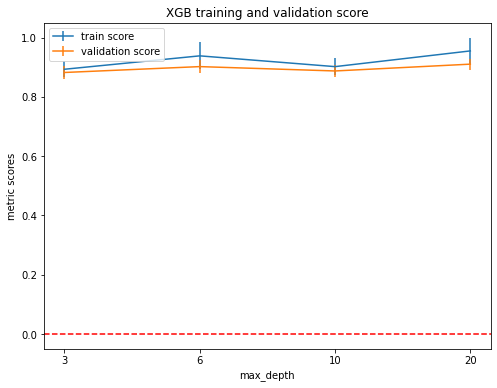

In [189]:
plt.figure(figsize=(8,6))
for i in ['train score','validation score']:
    plt.errorbar(xgb_depth,
                xgbdf[xgbdf['group']==i]["mean"], 
                yerr=rfdf[rfdf['group']==i]["stderr"],label=i)
plt.axhline(y=0 , color='r', linestyle='--')
plt.legend(loc='upper left')
plt.title("XGB training and validation score")
plt.xlabel('max_depth')
plt.ylabel('metric scores')
 

Text(0, 0.5, 'metric scores')

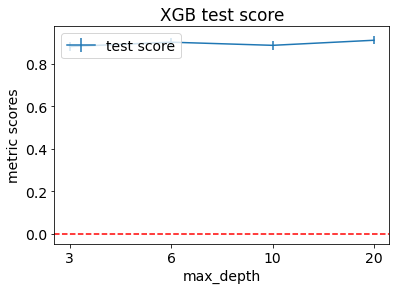

In [246]:
plt.errorbar(xgb_depth, test_mean,  test_std,label="test score")
plt.axhline(y=0 , color='r', linestyle='--')
plt.legend(loc='upper left')
plt.title("XGB test score")
plt.xlabel('max_depth')
plt.ylabel('metric scores')

---

### Part II, we explored the feature importance in both global and local environment

In [216]:
import warnings
import sklearn
import pandas as pd
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

#### Convert the X_train_prep into a dataset with corresponding column names

In [227]:
ftrs_test=get_feature_names(preprocessor)
ip_test_df=pd.DataFrame(X_test_prep, columns=ftrs_test)
ip_test_df

Transformer minmax (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
Transformer std (type StandardScaler) does not provide get_feature_names. Will return input column names if available


,minmax__arrival_date_week_number,minmax__arrival_date_day_of_month,onehot__x0_City Hotel,onehot__x0_Resort Hotel,onehot__x1_April,onehot__x1_August,onehot__x1_December,onehot__x1_February,onehot__x1_January,onehot__x1_July,...,std__children,std__agent,std__babies,std__previous_cancellations,std__previous_bookings_not_canceled,std__booking_changes,std__days_in_waiting_list,std__adr,std__required_car_parking_spaces,std__total_of_special_requests
0,0.230769,0.866667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.271280,-0.447878,-0.085344,-0.102588,-0.052943,-0.319326,-0.141352,-0.191038,-0.235469,0.496893
1,1.000000,0.866667,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.271280,1.207597,-0.085344,-0.102588,-0.052943,-0.319326,-0.141352,-0.674596,-0.235469,-0.757551
2,0.576923,0.133333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.151013,-0.004608,-0.085344,-0.102588,-0.052943,-0.319326,-0.141352,0.269310,-0.235469,0.496893
3,0.307692,0.600000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.271280,1.687052,-0.085344,-0.102588,-0.052943,-0.319326,-0.141352,-1.170533,-0.235469,-0.757551
4,0.596154,0.066667,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.271280,-0.773545,-0.085344,1.260595,-0.052943,-0.319326,-0.141352,-0.829334,-0.235469,-0.757551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20574,0.596154,0.033333,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.271280,1.388524,-0.085344,-0.102588,-0.052943,-0.319326,-0.141352,1.104898,-0.235469,1.751336
20575,0.365385,0.633333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.271280,1.289014,-0.085344,-0.102588,-0.052943,-0.319326,-0.141352,0.150741,-0.235469,0.496893
20576,0.269231,0.100000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.271280,1.913210,-0.085344,-0.102588,-0.052943,-0.319326,-0.141352,-0.384461,-0.235469,-0.757551
20577,0.711538,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.271280,-0.719267,-0.085344,-0.102588,-0.052943,-0.319326,-0.141352,-0.374790,-0.235469,-0.757551


#### Compute the permutation feature importance

In [229]:
nr_runs = 5
scores = np.zeros([len(ftrs_test),nr_runs])


# loop through the features
for i in range(len(ftrs_test)):
    print('shuffling '+str(ftrs_test[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = ip_test_df.copy()
        X_test_shuffled[ftrs_test[i]] = np.random.permutation(ip_test_df[ftrs_test[i]].values)
        new_test_y=rf.predict(X_test_shuffled)
        acc_scores.append(accuracy_score(y_test,new_test_y))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores


shuffling minmax__arrival_date_week_number
   shuffled test score: 0.769 +/- 0.0
shuffling minmax__arrival_date_day_of_month
   shuffled test score: 0.768 +/- 0.0
shuffling onehot__x0_City Hotel
   shuffled test score: 0.768 +/- 0.0
shuffling onehot__x0_Resort Hotel
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_April
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_August
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_December
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_February
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_January
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_July
   shuffled test score: 0.768 +/- 0.001
shuffling onehot__x1_June
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_March
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_May
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_November
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x1_October
   shu

   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_NOR
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_NPL
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_NZL
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_OMN
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_PAK
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_PAN
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_PER
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_PHL
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_PLW
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_POL
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_PRI
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_PRT
   shuffled test score: 0.656 +/- 0.002
shuffling onehot__x3_PRY
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_QAT
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x3_ROU
   shuffled test score: 0.769 +/- 0.0
shuffling oneho

   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-07
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-08
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-10
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-11
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-13
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-15
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-16
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-17
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-18
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-20
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-21
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-22
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-23
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-04-29
   shu

   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-21
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-22
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-23
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-24
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-25
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-26
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-27
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-28
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-29
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-30
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-08-31
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-09-01
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-09-02
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-09-03
   shu

   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-15
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-16
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-17
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-18
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-19
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-20
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-21
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-22
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-23
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-24
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-25
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-26
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-27
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2015-12-28
   shu

   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-09
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-10
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-11
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-12
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-13
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-14
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-15
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-16
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-17
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-18
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-19
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-20
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-21
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-04-22
   shu

   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-03
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-04
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-05
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-06
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-07
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-08
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-09
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-10
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-11
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-12
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-13
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-14
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-15
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-08-16
   shu

   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-11-27
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-11-28
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-11-29
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-11-30
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-01
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-02
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-03
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-04
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-05
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-06
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-07
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-08
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-09
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2016-12-10
   shu

   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-03-23
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-03-24
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-03-25
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-03-26
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-03-27
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-03-28
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-03-29
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-03-30
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-03-31
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-04-01
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-04-02
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-04-03
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-04-04
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-04-05
   shu

   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-17
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-18
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-19
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-20
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-21
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-22
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-23
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-24
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-25
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-26
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-27
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-28
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-29
   shuffled test score: 0.769 +/- 0.0
shuffling onehot__x10_2017-07-30
   shu

#### Visualize the result

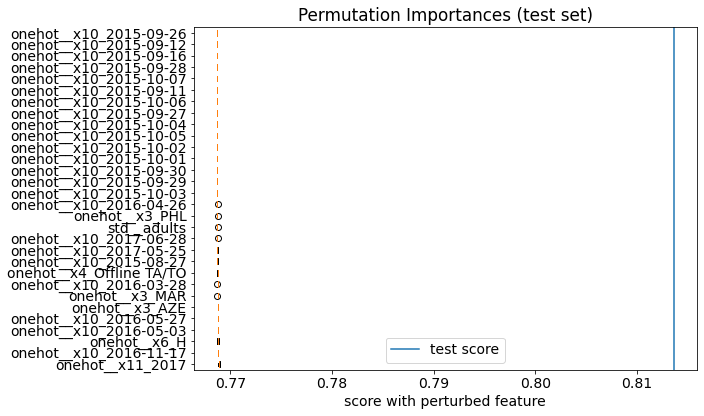

In [256]:
ftrs_test_ip=pd.Series(ftrs_test)
iptest_score = accuracy_score(rf.predict(X_test_prep),y_test)
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1][0:30]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,6))
plt.boxplot(scores[sorted_indcs].T, labels=ftrs_test_ip[sorted_indcs],vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.axvline(iptest_score,label='test score')
plt.legend()
plt.tight_layout()
plt.show()

### VI. Save model for future use

In [262]:
import pickle
# random forest model
model = RandomForestClassifier(n_estimators=1, max_depth=200)
# fit the model
model.fit(X_train_prep, y_train)


filename = 'rf_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [263]:
# logistic regression
model = LogisticRegression(solver='lbfgs')
# fit the model
model.fit(X_train_prep,y_train)


filename = 'lg_model.sav'
pickle.dump(model, open(filename, 'wb'))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [265]:
# XGBoost
model = xgboost.XGBClassifier(max_depth=20)
# fit the model
model.fit(X_train_prep, y_train)

filename = 'xgb_model.sav'
pickle.dump(model, open(filename, 'wb'))

**Ending**


The analysis is still a rudimentary version, which can be better improved with future effort. But I received much fun in exploring the data and gain a new perepsective when leading the machine learning models. Thanks for checking the notebook, and please feel free to provide me with any feedbacks.

---